## Blosum strategies
* This file compares using the original blosum rows as features vs. doing eigenvalue decomposition and then constructing features

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids

NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*12 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
uniform_pvals = [0.05]*20

encoding_style = 'regular'
alpha=7
beta=0.1

In [3]:
# New distribution (not NNK exactly)
aa_list_2 = ["A", "C", "D", "E", "F", "G", "H",  "I",  "K",  "L",  "M",  "N", "P", "Q", "R", "S", "T", "V",  "W", "Y"]
pvals_2 = [0.07668660126327106, 0.035596693992742914, 0.02474465797607849, 0.04041795457599785, 0.02319916677865878, 0.1149711060341352, 0.02187206020696143, 0.021972853111140975, 0.030170675984410696, 0.0904280338664158, 0.030069883080231154, 0.017672355866147026, 0.03937642789947588, 0.03156497782556108, 0.1183812659588765, 0.07880325225104153, 0.043290552345114905, 0.08557317564843435, 0.053369842763069476, 0.02183846257223492]

In [4]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding

In [5]:
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

In [6]:
# Biological features
# kd hydrophobicity scale
hydrophobicity = {'G': -0.4, 'A': 1.8, 'L':3.8, 'M': 1.9, 'F':2.8, 'W':-0.9, 'K':-3.9, 'Q':-3.5, 'E':-3.5, 'S':-0.8, 'P':-1.6, 'V':4.2, 'I':4.5, 'C':2.5, 'Y':-1.3, 'H':-3.2, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'T':-0.7}
# Ranked
polarity = {'A': 0.45, 'R': 0.75, 'N': 0.8, 'D': 0.95, 'C':0.35, 'Q': 0.85, 'E': 0.90, 'G': 0.55, 'H': 0.5, 'I': 0.05, 'L': 0.15, 'K': 1, 'M': 0.25, 'F': 0.1, 'P': 0.65, 'S': 0.7, 'T': 0.6, 'W': 0.3, 'Y': 0.4, 'V': 0.2}
# Van der waal's volume
volume = {'A': 67, 'R': 148, 'N': 96, 'D': 91, 'C':86, 'Q': 114, 'E': 109, 'G': 48, 'H': 118, 'I': 124, 'L': 124, 'K': 135, 'M': 124, 'F': 135, 'P': 90, 'S': 73, 'T': 93, 'W':163, 'Y':141, 'V': 105}

# TODO: branched, hydrophilic, hydrophobic, shape
charge = {'A': 2, 'R': 3, 'N': 2, 'D': 1, 'C': 2, 'E':1, 'Q':2, 'G':2, 'H': 3, 'I':2, 'L': 2, 'K': 3, 'M':2, 'F':2, 'P':2, 'S':2, 'T': 2, 'W':2, 'Y': 2, 'V':2 }

# Normalize all of the biological features:
# Charge
for k,v in charge.items():
    if v == 1:
        charge[k] = 0
    elif v == 2:
        charge[k] = 0.5
    else:
        charge[k] = 1.0

# Volume
for k,v in volume.items():
    volume[k] = v/163.0

#Polarity
min_v = -4.5
max_v = 4.5
for k,v in hydrophobicity.items():
    hydrophobicity[k] = (v - min_v)/(max_v - min_v)  

## Dataset

In [7]:
class BinaryDataset(Dataset):
    def __init__(self, filepath, distribution='NNK', negfilepath=None):
        def construct_binary_dataset(filepath, distribution='NNK', negfilepath=None):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            pos_ds = []
            neg_ds = []
            gen_ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    pos_ds.append((aptamer, peptide, 1))
                    gen_ds.append((get_x(), get_y(distribution), 0))
            with open(negfilepath, 'r') as f:
                neg_data = json.load(f)
            for aptamer in neg_data:
                peptides = neg_data[aptamer]
                for peptide in peptides:
                    neg_ds.append((aptamer, peptide, 0))
            
            pos_ds = list(set(pos_ds)) #removed duplicates, random order
            neg_ds = list(set(neg_ds))
            gen_ds = list(set(gen_ds))
            return pos_ds, neg_ds, gen_ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.pos_ds, self.neg_ds, self.gen_ds =construct_binary_dataset(filepath, distribution, negfilepath)

    def __len__(self):
        return min(len(self.pos_ds), len(self.neg_ds))

    def __getitem__(self,idx):
        return(self.pos_ds[idx], self.neg_ds[idx], self.gen_ds[idx])

In [8]:
class AUCDataset(Dataset):
    def __init__(self, filepath, negfilepath=None):
        def construct_dataset(filepath, negfilepath=None):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            bio_ds = []
            neg_ds = []
            gen_ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    bio_ds.append((aptamer, peptide, 1))
                    gen_ds.append((get_x(), get_y('NNK'), 0))
            with open(negfilepath, 'r') as f:
                neg_data = json.load(f)
            for aptamer in neg_data:
                peptides = neg_data[aptamer]
                for peptide in peptides:
                    neg_ds.append((aptamer, peptide, 0))
            bio_ds = list(set(bio_ds)) #removed duplicates, random order
            gen_ds = list(set(gen_ds)) #removed duplicates, random order
            neg_ds = list(set(neg_ds))
 
            return bio_ds, neg_ds, gen_ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x
        
         # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution='NNK'):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.bio_ds, self.neg_ds, self.gen_ds = construct_dataset(filepath, negfilepath)

    def __len__(self):
        return min(len(self.bio_ds), len(self.neg_ds))

    def __getitem__(self,idx):
        return(self.bio_ds[idx], self.neg_ds[idx], self.gen_ds[idx])

In [9]:
binary_ds1=BinaryDataset(filepath="../data/experimental_replicate_1.json", distribution='NNK', negfilepath='../data/neg_datasets/neg1_all_pairs_noArgi_noHis.json')
binary_ds2=BinaryDataset(filepath="../data/experimental_replicate_2.json", distribution='NNK', negfilepath='../data/neg_datasets/neg2_all_pairs_noArgi_noHis.json')
n = len(binary_ds1.pos_ds)
m = int(0.8*n)
train_pos = binary_ds1.pos_ds[:m]
val_pos = binary_ds1.pos_ds[m:]
n = len(binary_ds1.neg_ds)
m = int(0.8*n)
train_neg = binary_ds1.neg_ds[:m]
val_neg = binary_ds1.neg_ds[m:]
n = len(binary_ds1.gen_ds)
m = int(0.8*n)
train_gen = binary_ds1.gen_ds[:m]
val_gen = binary_ds1.gen_ds[m:]

n = len(binary_ds2.pos_ds)
m = int(0.8*n)
train_pos2 = binary_ds2.pos_ds[:m]
val_pos2 = binary_ds2.pos_ds[m:]
n = len(binary_ds2.neg_ds)
m = int(0.8*n)
train_neg2 = binary_ds2.neg_ds[:m]
val_neg2 = binary_ds2.neg_ds[m:]
n = len(binary_ds2.gen_ds)
m = int(0.8*n)
train_gen2 = binary_ds2.gen_ds[:m]
val_gen2 = binary_ds2.gen_ds[m:]

train_pos += train_pos2
train_neg += train_neg2
train_gen += train_gen2
val_pos += val_pos2
val_neg += val_neg2
val_gen += val_gen2


In [ ]:
auc_ds_1 = AUCDataset(filepath='../data/experimental_replicate_3.json', negfilepath='../data/neg_datasets/neg3_all_pairs_noArgi_noHis.json')
auc_ds_2 = AUCDataset(filepath='../data/experimental_replicate_4.json', negfilepath='../data/neg_datasets/neg4_all_pairs_noArgi_noHis.json')

## NN Model

In [10]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumConvNet(nn.Module):
    def __init__(self):
        super(BlosumConvNet, self).__init__()
        self.name = "BlosumConvNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 100, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(100, 200, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(200, 300, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 100, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(200, 300, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(300, 350, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(1400, 700 )
        self.fc2 = nn.Linear(700, 250)
        self.fc3 = nn.Linear(250, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [12]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [13]:
class LinearBaseline(nn.Module):
    def __init__(self):
        super(LinearBaseline, self).__init__()
        self.name = "LinearBaseline"
        self.single_alphabet = False
        
        self.fc_1 = nn.Linear(320, 1)
    
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [14]:
class ConvBaseline(nn.Module):
    def __init__(self):
        super(ConvBaseline, self).__init__()
        self.name = "ConvBaseline"
        self.single_alphabet = True
        
        self.cnn_1 = nn.Conv1d(24, 1000, 3)
        self.fc_1 = nn.Linear(6000, 1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(7) 
        
    
    def forward(self, pair):
        x = self.cnn_1(pair)
        x = self.relu(self.maxpool(x))
        x = x.view(-1, 1).T
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [24]:
class TwoHeadedConv(nn.Module):
    def __init__(self):
        super(TwoHeadedConv, self).__init__()
        self.name = "TwoHeadedConv"
        self.single_alphabet=False
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2)
        self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(1000, 500, 3, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(3)
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu,
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     )
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     )
        self.fc1 = nn.Linear(3000, 1)

    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x          

In [16]:
class ConvTwoHead(nn.Module):
    def __init__(self):
        super(ConvTwoHead, self).__init__()
        self.name = "ConvTwoHead"
        self.single_alphabet=False
        
        self.cnn_apt_1 = nn.Conv1d(4, 100, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(50, 150, 3, padding=2) 

        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 100, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(75, 150, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     )
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     )
        
        self.fc1 = nn.Linear(2600, 1300)
        self.fc2 = nn.Linear(1300, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [17]:
class TwoHeadedConv(nn.Module):
    def __init__(self):
        super(TwoHeadedConv, self).__init__()
        self.name = "TwoHeadedConv"
        self.single_alphabet=False
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2)
        self.cnn_apt_2 = nn.Conv1d(1000, 2000, 3, padding=2)
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(1000, 2000, 3, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(3)
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu,
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     )
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     )
        self.fc1 = nn.Linear(12000, 5000)
        self.fc2 = nn.Linear(5000, 1)
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [18]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [26]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        encoding = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                encoding[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for j in range(len(original_blosum62[char])):
                encoding[i+len(apt)][j+4] = original_blosum62[char][j]
        
        return encoding      
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to directly translated sequence
def translate(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        
        encoding = np.zeros(len(apt) + len(pep))
        
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            idx = na_list.index(char)
            encoding[i] = idx
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            idx = aa_list.index(char)
            encoding[i+len(apt)] = idx
        return encoding     
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        
        encoding = np.zeros(len(sequence))
        for i in range(len(sequence)):
            char = sequence[i]
            idx = letters.index(char)
            encoding[i] = idx
        return encoding

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False, use_blosum=True): 
    if single_alphabet:
        if use_blosum:
            pair = blosum62_encoding([apt, pep], single_alphabet=True) #(2, 40)
        else:
            pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[1], pair.shape[0]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer')
        if use_blosum:
            pep = blosum62_encoding(pep, seq_type='peptide')
        else:
            pep = one_hot(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 1, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

In [20]:
# Test the translate method with single alphabet
pair, label = convert("GGGG", "LL", label=1.0, single_alphabet=True)
pair.shape

torch.Size([1, 24, 6])

## Binary Classification

In [21]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [22]:
def classifier(model, 
               pos, 
               neg,
               gen,
               val_pos,
               val_neg,
               val_gen,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None,
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    # Number of times that val_score < train_score
    auc_tracker = 0
    auc_count = 0
    
    alpha = 0.9
    beta = 0.1
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i in tqdm.tqdm(range(100000)):
            
            num = random.uniform(0, 1)
            if num < 0.33:
                lam = 1
                apt,pep,label = random.choice(pos)
            elif num >= 0.33 and num < 0.67:
                lam = alpha
                apt,pep,label = random.choice(neg)
            elif num >= 0.67 and num <= 1:
                lam = beta
                apt,pep,label = random.choice(gen)
            
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            # The original label is non binding
            if label == 0.0:
                train_gen_scores.append(train_score.item())
                # Score is non binding
                if train_score.item() < 0.5:
                    train_stats[1] += 1
                    train_correct += 1
                # Score is binding
                else:
                    train_stats[2] += 1
            # The original label is binding
            elif label == 1.0:
                train_scores.append(train_score.item())
                # The score is binding
                if train_score.item() >= 0.5:
                    train_correct += 1
                    train_stats[0] += 1
                # The score is nonbinding
                else:
                    train_stats[3] += 1
                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss

            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            
            
            num = random.uniform(0, 1+alpha+beta)
            if num < 1:
                apt,pep,label = random.choice(val_pos)
            elif num >= 1 and num < (1+alpha):
                apt,pep,label = random.choice(val_neg)
            elif num >= (1+alpha) and num < (1+alpha+beta):
                apt,pep,label = random.choice(val_gen)
                
                
            if single_alphabet:
                p_val, l_val = convert(apt, pep, label, single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(apt,pep,label)
                val_score = model(a_val, p_val)
            
            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss
            
            # Calculate AUC
            auc_count += 1
            idx = int(random.random()*len(val_pos))
            bio_sample = val_pos[idx]
            idx = int(random.random()*len(val_neg))
            gen_sample = val_neg[idx]
            if single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
                bio_score = model(p)
                p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
                gen_score = model(p)
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
                bio_score = model(a, p)
                a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
                gen_score = model(a, p)
            if bio_score > gen_score:
                auc_tracker += 1
            
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
                if val_score.item() < 0.5:
                    val_stats[1] += 1
                    val_correct += 1
                else:
                    val_stats[2] += 1
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
                if val_score.item() >= 0.5:
                    val_stats[0] += 1
                    val_correct += 1
                else:
                    val_stats[3] += 1

            
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))
                
            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                #val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                #train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
                #print("Training CDF at epoch %d: {}".format(train_auc) % full_epoch)
                #print("Validation CDF epoch %d: {}".format(val_auc) % full_epoch)
                print("AUC epoch %d: {}".format(auc_tracker/float(auc_count)) % full_epoch)
                #print("Train: Sensitivity: " + str(train_stats[0]/(train_stats[0] + train_stats[3])) + " Specificity: " + str(train_stats[1]/(train_stats[2] + train_stats[1])))
                #print("Val: Sensitivity: " + str(val_stats[0]/(val_stats[0] + val_stats[3])) + " Specificity: " + str(val_stats[1]/(val_stats[2] + val_stats[1])))
                # TP, TN, FP, FN
                print("Train Precision: ", train_stats[0]/(train_stats[0] + train_stats[2]))
                print("Train Recall: ", train_stats[0]/(train_stats[0] + train_stats[3]))

        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 11/100000 [00:00<16:25, 101.43it/s]

Using encoding_style= regular
Starting epoch: 0  with learning rate:  [0.01]


 50%|████▉     | 49999/100000 [10:36<11:42, 71.20it/s] 

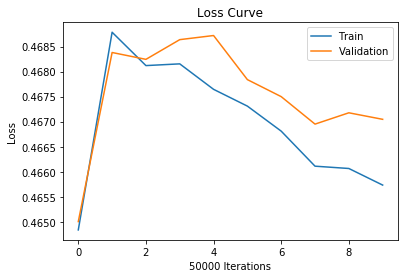

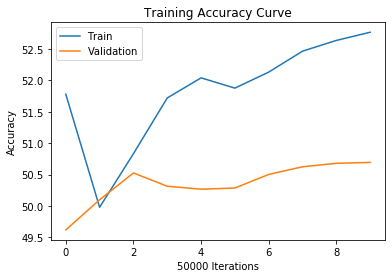

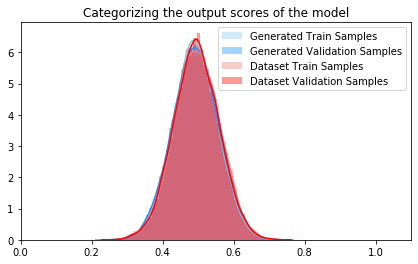

 50%|█████     | 50017/100000 [10:39<55:20, 15.05it/s]  

Training Accuracy at epoch 0: 52.766
Validation Accuracy epoch 0: 50.694
AUC epoch 0: 0.5247
Train Precision:  0.3441524310118265
Train Recall:  0.4761529604266408


100%|█████████▉| 99995/100000 [20:32<00:00, 86.17it/s] 

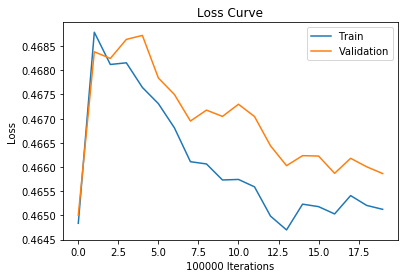

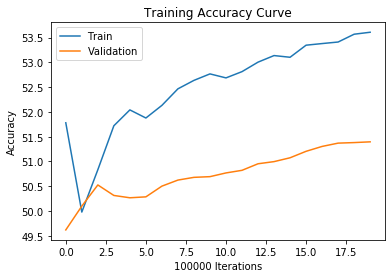

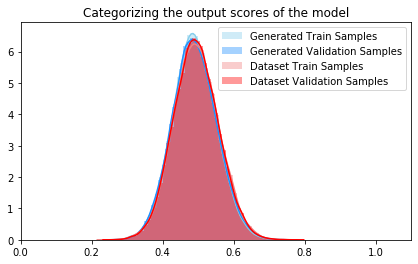

  0%|          | 11/100000 [00:00<16:03, 103.78it/s]

Training Accuracy at epoch 0: 53.606
Validation Accuracy epoch 0: 51.396
AUC epoch 0: 0.5317
Train Precision:  0.3456648984817999
Train Recall:  0.45959749498388763
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 1  with learning rate:  [0.01]


 50%|████▉     | 49997/100000 [09:37<09:05, 91.60it/s] 

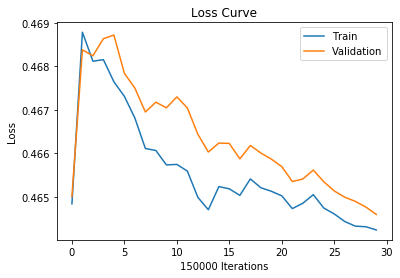

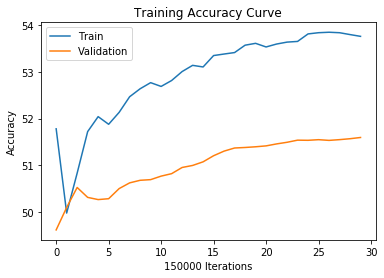

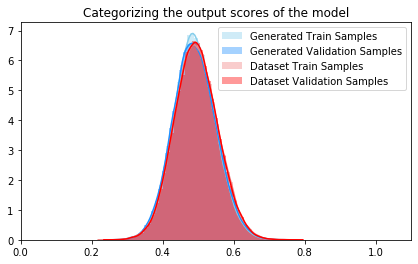

 50%|█████     | 50007/100000 [09:40<1:18:20, 10.63it/s]

Training Accuracy at epoch 1: 53.75533333333333
Validation Accuracy epoch 1: 51.59466666666667
AUC epoch 1: 0.53428
Train Precision:  0.3460859690315056
Train Recall:  0.45737000081122736


100%|█████████▉| 99992/100000 [19:24<00:00, 86.98it/s]  

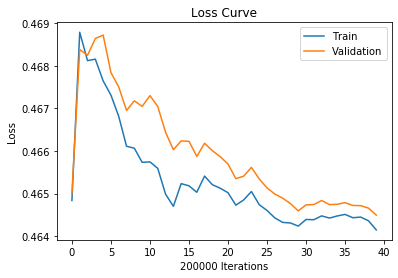

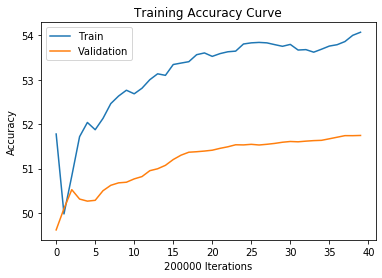

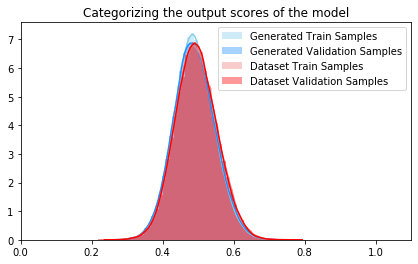

  0%|          | 10/100000 [00:00<17:34, 94.80it/s]

Training Accuracy at epoch 1: 54.072
Validation Accuracy epoch 1: 51.7475
AUC epoch 1: 0.538125
Train Precision:  0.34785041499580344
Train Recall:  0.45382649957415744
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 2  with learning rate:  [0.01]


 50%|████▉     | 49991/100000 [10:26<12:49, 65.03it/s] 

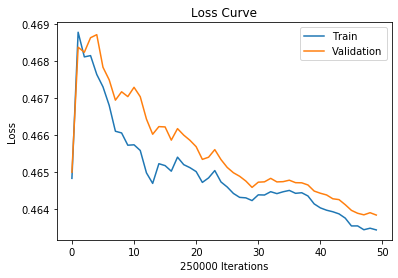

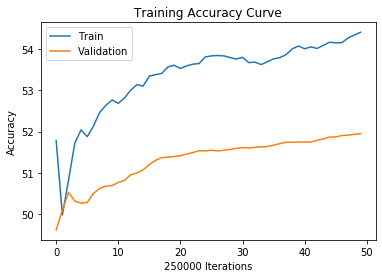

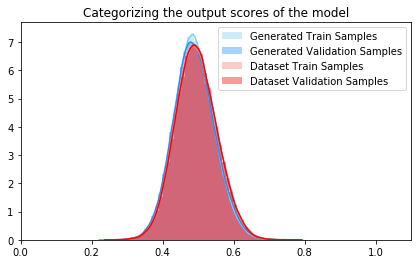

 50%|█████     | 50010/100000 [10:30<1:29:20,  9.33it/s]

Training Accuracy at epoch 2: 54.4052
Validation Accuracy epoch 2: 51.9468
AUC epoch 2: 0.539332
Train Precision:  0.3507321969661435
Train Recall:  0.45502896645732926


100%|█████████▉| 99994/100000 [20:57<00:00, 80.92it/s]  

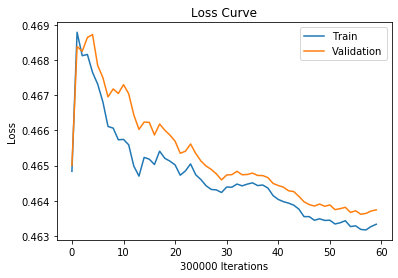

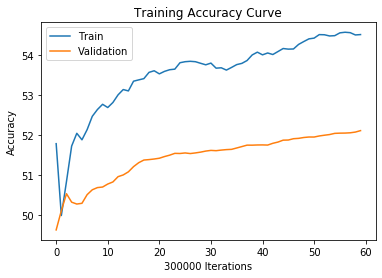

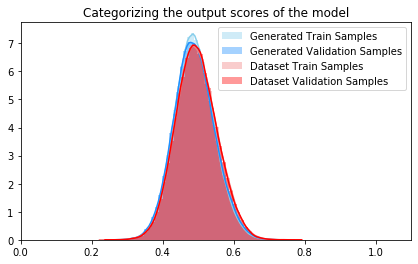

  0%|          | 10/100000 [00:00<17:32, 95.05it/s]

Training Accuracy at epoch 2: 54.51266666666667
Validation Accuracy epoch 2: 52.10666666666667
AUC epoch 2: 0.5407666666666666
Train Precision:  0.35269826152801304
Train Recall:  0.4576542447048813
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 3  with learning rate:  [0.01]


 50%|████▉     | 49993/100000 [10:13<10:06, 82.42it/s] 

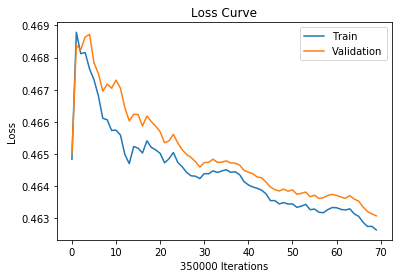

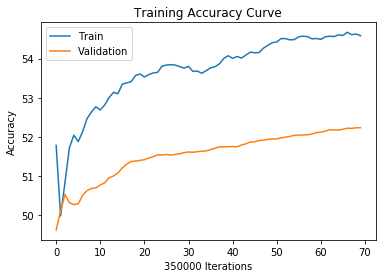

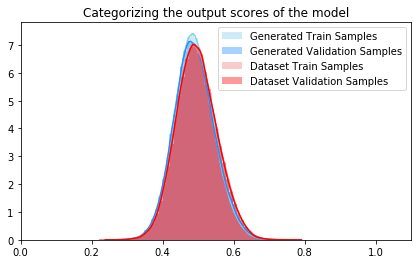

 50%|█████     | 50011/100000 [10:17<1:40:38,  8.28it/s]

Training Accuracy at epoch 3: 54.582857142857144
Validation Accuracy epoch 3: 52.23085714285714
AUC epoch 3: 0.5427114285714286
Train Precision:  0.35402867359556195
Train Recall:  0.4594686028053192


100%|█████████▉| 99996/100000 [20:37<00:00, 91.41it/s]  

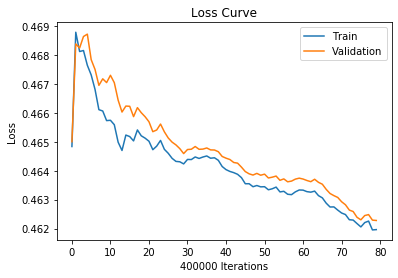

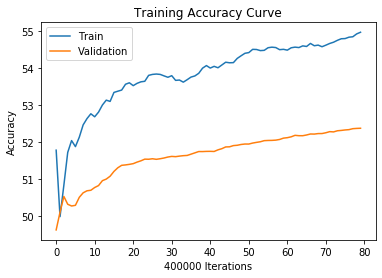

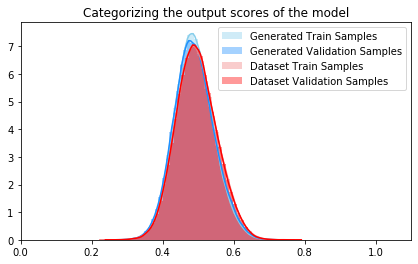

  0%|          | 9/100000 [00:00<19:52, 83.83it/s]

Training Accuracy at epoch 3: 54.97525
Validation Accuracy epoch 3: 52.37425
AUC epoch 3: 0.54441
Train Precision:  0.3556728012467434
Train Recall:  0.4544694499547773
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 4  with learning rate:  [0.01]


 50%|████▉     | 49990/100000 [10:26<12:33, 66.35it/s] 

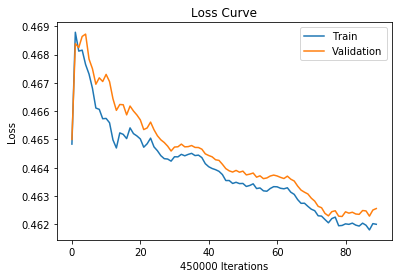

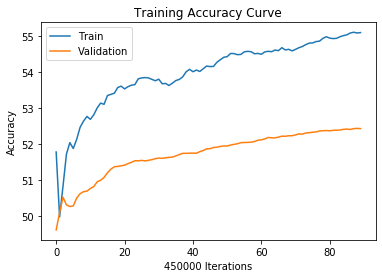

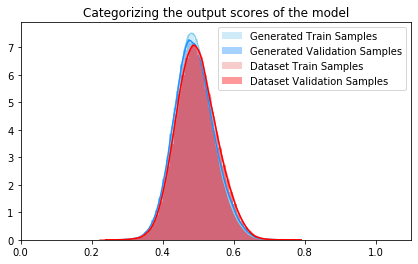

 50%|█████     | 50009/100000 [10:31<1:43:05,  8.08it/s]

Training Accuracy at epoch 4: 55.090444444444444
Validation Accuracy epoch 4: 52.428222222222225
AUC epoch 4: 0.54594
Train Precision:  0.3574910902188052
Train Recall:  0.4562220377755734


100%|█████████▉| 99999/100000 [21:02<00:00, 79.84it/s]  

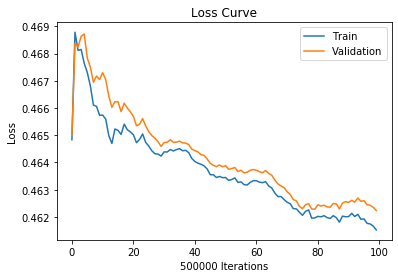

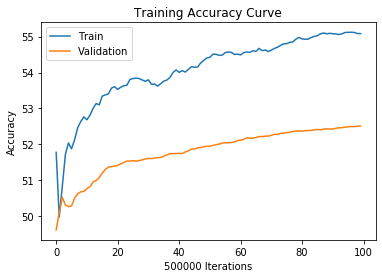

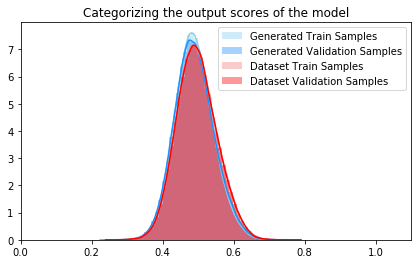

  0%|          | 10/100000 [00:00<18:21, 90.75it/s]

Training Accuracy at epoch 4: 55.083
Validation Accuracy epoch 4: 52.5114
AUC epoch 4: 0.546946
Train Precision:  0.35838974499874465
Train Recall:  0.45907717326666586
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 5  with learning rate:  [0.01]


 50%|████▉     | 49995/100000 [10:10<09:46, 85.31it/s] 

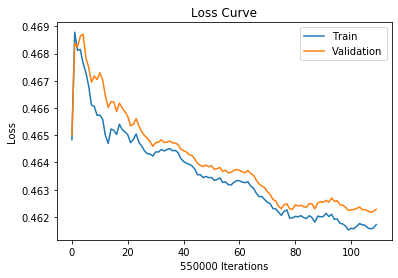

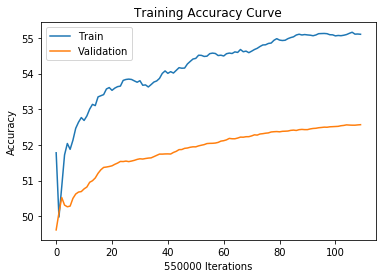

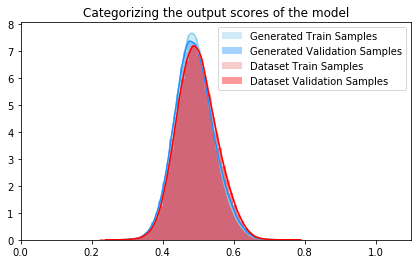

 50%|█████     | 50014/100000 [10:17<2:04:59,  6.67it/s]

Training Accuracy at epoch 5: 55.09854545454545
Validation Accuracy epoch 5: 52.566545454545455
AUC epoch 5: 0.5479781818181818
Train Precision:  0.35912482762472236
Train Recall:  0.4609065296378182


100%|█████████▉| 99991/100000 [20:37<00:00, 88.38it/s]  

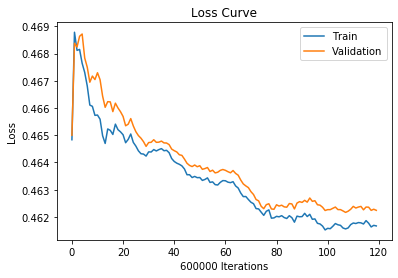

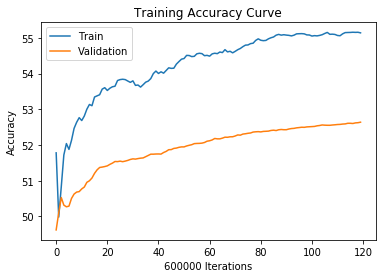

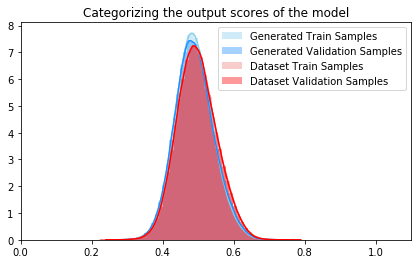

  0%|          | 9/100000 [00:00<19:59, 83.36it/s]

Training Accuracy at epoch 5: 55.143166666666666
Validation Accuracy epoch 5: 52.639
AUC epoch 5: 0.5484466666666666
Train Precision:  0.3597436564018938
Train Recall:  0.4614424655803966
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 6  with learning rate:  [0.01]


 50%|████▉     | 49997/100000 [10:17<11:30, 72.41it/s] 

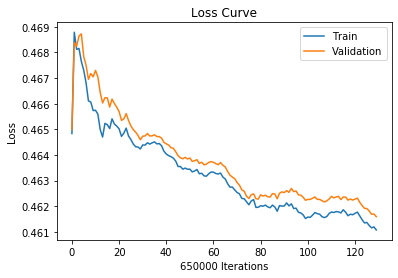

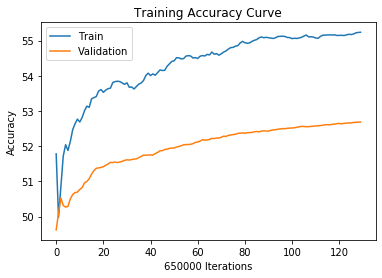

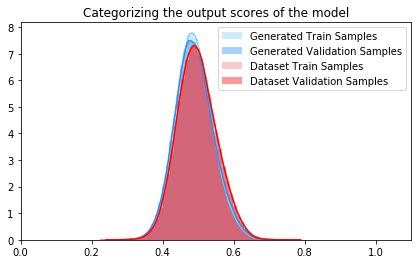

 50%|█████     | 50016/100000 [10:24<2:17:32,  6.06it/s]

Training Accuracy at epoch 6: 55.23461538461538
Validation Accuracy epoch 6: 52.68523076923077
AUC epoch 6: 0.5491646153846154
Train Precision:  0.3604991695078241
Train Recall:  0.461659024438028


100%|█████████▉| 99997/100000 [20:56<00:00, 79.50it/s]  

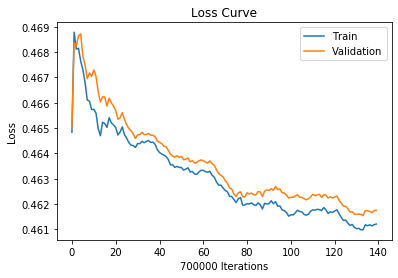

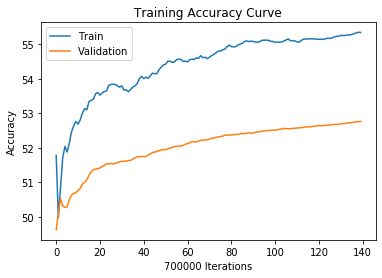

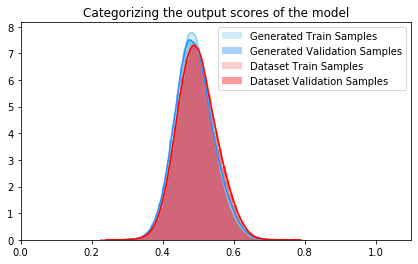

  0%|          | 10/100000 [00:00<17:22, 95.89it/s]

Training Accuracy at epoch 6: 55.342285714285715
Validation Accuracy epoch 6: 52.763714285714286
AUC epoch 6: 0.5495985714285714
Train Precision:  0.36162922584686225
Train Recall:  0.4626429935850511
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 7  with learning rate:  [0.01]


 50%|████▉     | 49993/100000 [10:17<09:24, 88.51it/s] 

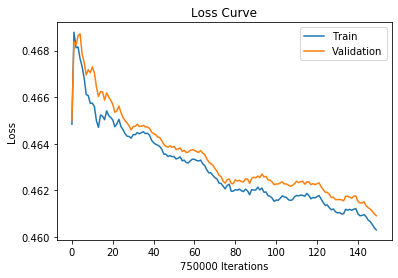

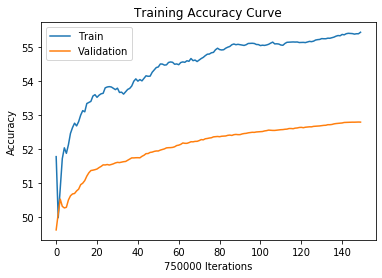

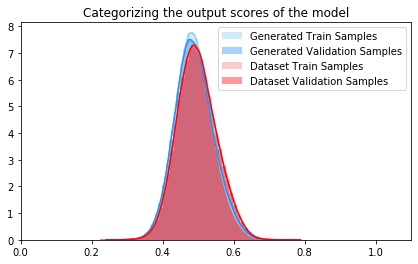

 50%|█████     | 50014/100000 [10:25<2:18:22,  6.02it/s]

Training Accuracy at epoch 7: 55.4464
Validation Accuracy epoch 7: 52.797333333333334
AUC epoch 7: 0.5502426666666667
Train Precision:  0.3624651634152521
Train Recall:  0.4628137939958592


100%|█████████▉| 99998/100000 [20:41<00:00, 90.07it/s]  

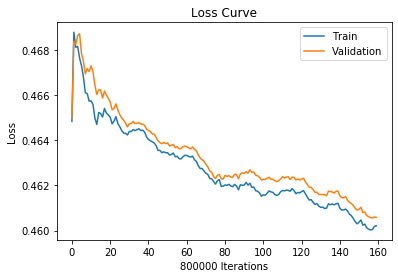

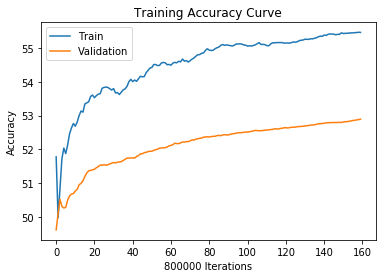

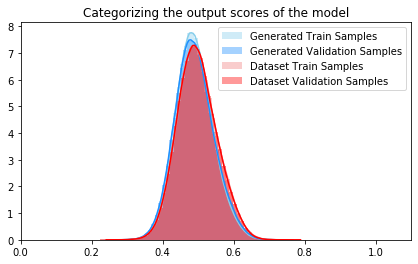

  0%|          | 10/100000 [00:00<17:33, 94.89it/s]

Training Accuracy at epoch 7: 55.4595
Validation Accuracy epoch 7: 52.894
AUC epoch 7: 0.550995
Train Precision:  0.3635809771678694
Train Recall:  0.4655321276015632
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 8  with learning rate:  [0.01]


 50%|████▉     | 49990/100000 [10:15<12:38, 65.97it/s] 

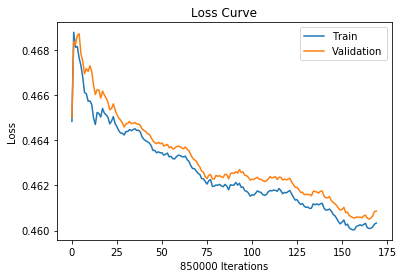

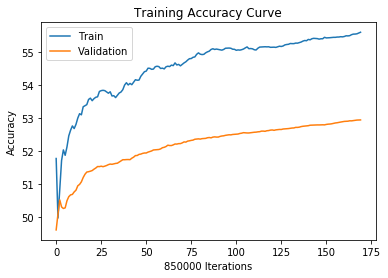

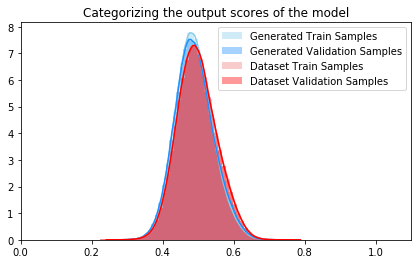

 50%|█████     | 50010/100000 [10:23<2:29:08,  5.59it/s]

Training Accuracy at epoch 8: 55.59917647058823
Validation Accuracy epoch 8: 52.946823529411766
AUC epoch 8: 0.5512117647058824
Train Precision:  0.36435684600822216
Train Recall:  0.46377813820022457


100%|█████████▉| 99989/100000 [20:02<00:00, 82.49it/s]  

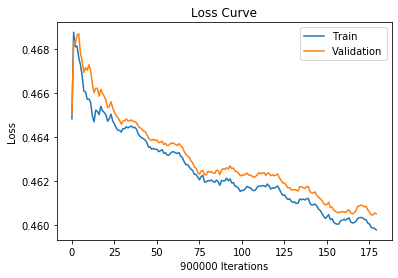

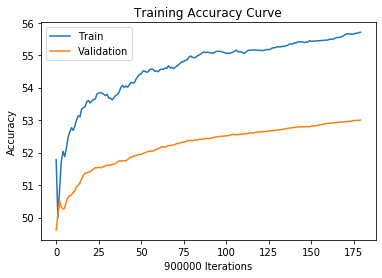

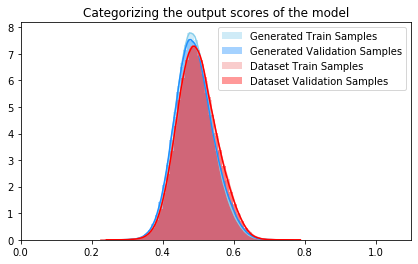

  0%|          | 11/100000 [00:00<15:49, 105.33it/s]

Training Accuracy at epoch 8: 55.705666666666666
Validation Accuracy epoch 8: 53.00255555555555
AUC epoch 8: 0.5518
Train Precision:  0.36522301570891585
Train Recall:  0.4639500543838795
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 9  with learning rate:  [0.01]


 50%|████▉     | 49990/100000 [09:19<08:49, 94.36it/s] 

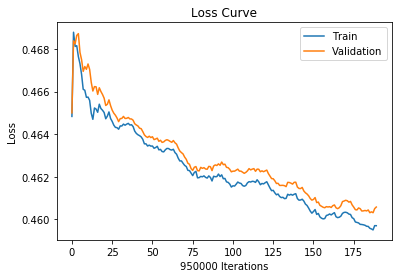

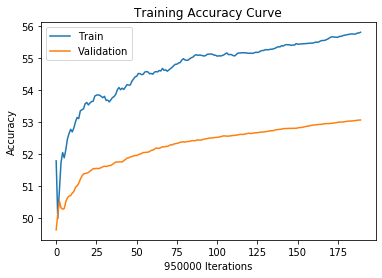

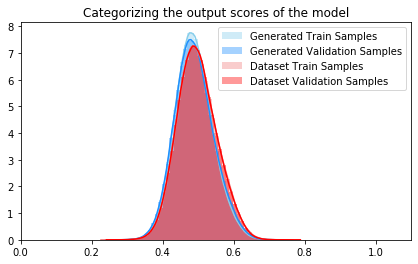

 50%|█████     | 50010/100000 [09:28<2:35:42,  5.35it/s]

Training Accuracy at epoch 9: 55.80178947368421
Validation Accuracy epoch 9: 53.05768421052632
AUC epoch 9: 0.5523652631578947
Train Precision:  0.366168666213939
Train Recall:  0.464440779294526


100%|█████████▉| 99995/100000 [18:51<00:00, 97.08it/s]  

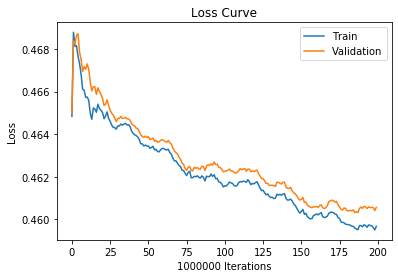

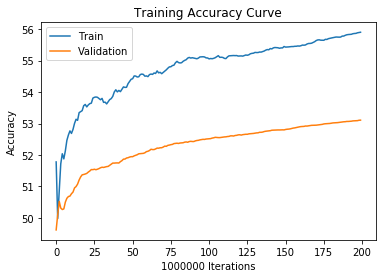

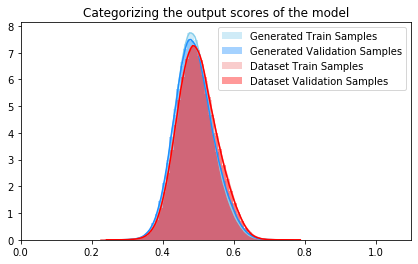

  0%|          | 10/100000 [00:00<17:08, 97.26it/s]

Training Accuracy at epoch 9: 55.8998
Validation Accuracy epoch 9: 53.1068
AUC epoch 9: 0.552846
Train Precision:  0.3667844370511702
Train Recall:  0.46391368145327544
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 10  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49989/100000 [09:21<10:47, 77.26it/s] 

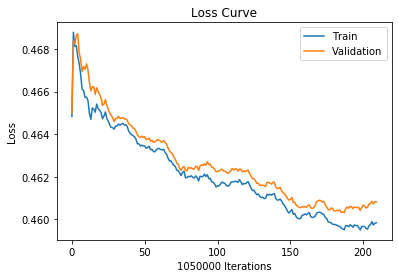

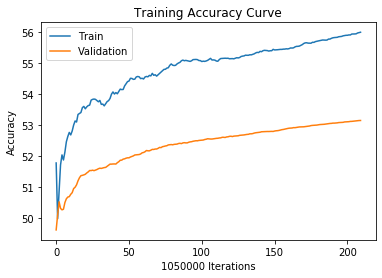

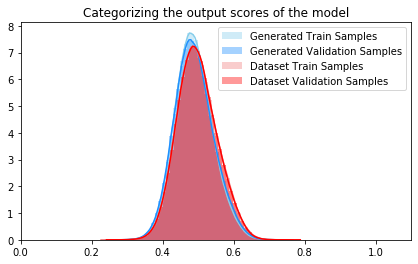

 50%|█████     | 50011/100000 [09:30<2:31:47,  5.49it/s]

Training Accuracy at epoch 10: 55.99847619047619
Validation Accuracy epoch 10: 53.15114285714286
AUC epoch 10: 0.5532819047619048
Train Precision:  0.3676578258561675
Train Recall:  0.46397676218195255


100%|█████████▉| 99990/100000 [18:53<00:00, 85.60it/s]  

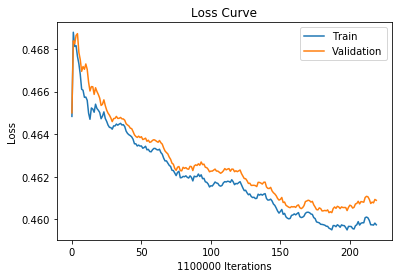

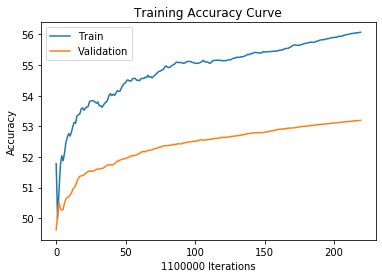

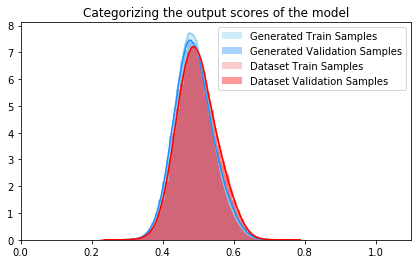

  0%|          | 11/100000 [00:00<15:55, 104.66it/s]

Training Accuracy at epoch 10: 56.07354545454545
Validation Accuracy epoch 10: 53.19827272727273
AUC epoch 10: 0.5535418181818181
Train Precision:  0.36865078498591614
Train Recall:  0.4652491298848389
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 11  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49989/100000 [09:10<08:47, 94.87it/s] 

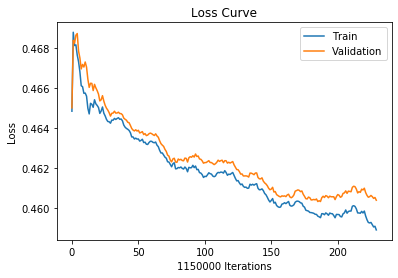

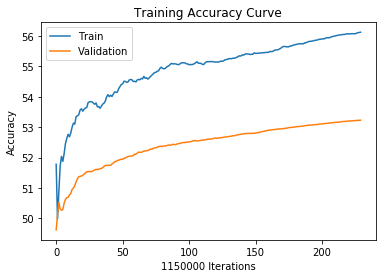

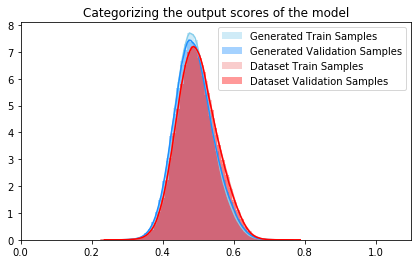

 50%|█████     | 50011/100000 [09:20<2:37:02,  5.31it/s]

Training Accuracy at epoch 11: 56.12513043478261
Validation Accuracy epoch 11: 53.230347826086955
AUC epoch 11: 0.5539913043478261
Train Precision:  0.36919783192171524
Train Recall:  0.4659965094881813


100%|█████████▉| 99997/100000 [18:38<00:00, 97.91it/s]  

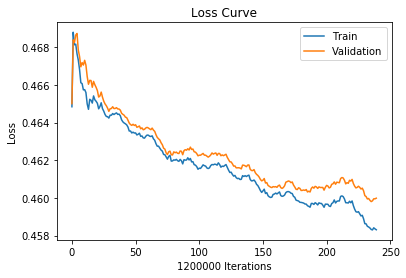

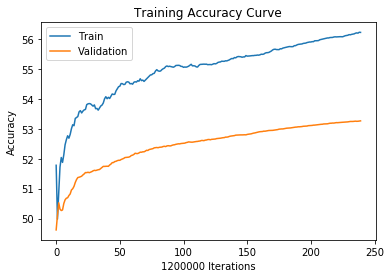

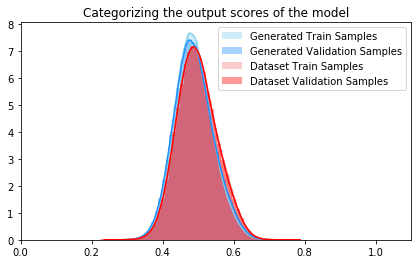

  0%|          | 10/100000 [00:00<17:09, 97.12it/s]

Training Accuracy at epoch 11: 56.22116666666667
Validation Accuracy epoch 11: 53.26416666666667
AUC epoch 11: 0.5541658333333334
Train Precision:  0.369776894589468
Train Recall:  0.4656831642622594
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 12  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49992/100000 [09:22<10:55, 76.34it/s] 

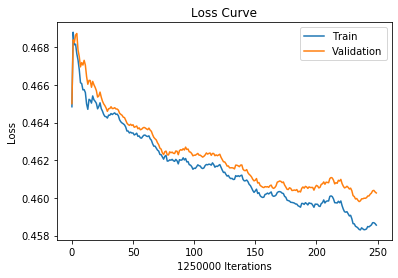

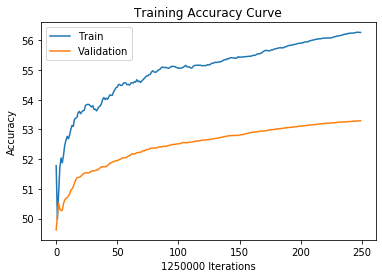

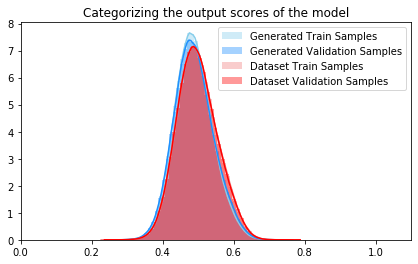

 50%|█████     | 50012/100000 [09:33<3:29:09,  3.98it/s]

Training Accuracy at epoch 12: 56.26184
Validation Accuracy epoch 12: 53.28928
AUC epoch 12: 0.5546416
Train Precision:  0.37032796964107784
Train Recall:  0.4661930687784474


100%|█████████▉| 99997/100000 [18:52<00:00, 89.28it/s]  

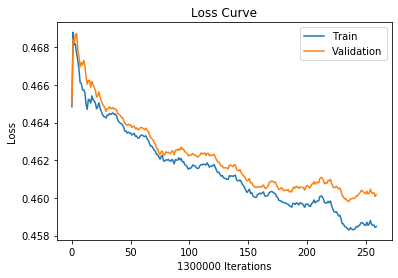

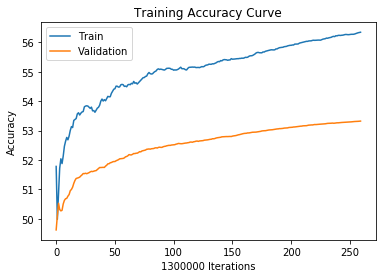

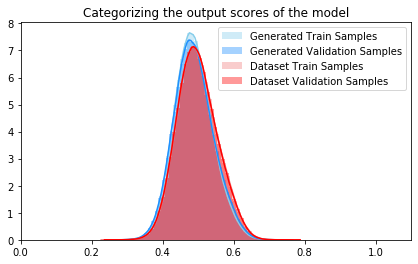

  0%|          | 11/100000 [00:00<16:04, 103.67it/s]

Training Accuracy at epoch 12: 56.344846153846156
Validation Accuracy epoch 12: 53.32192307692308
AUC epoch 12: 0.5549038461538461
Train Precision:  0.3708461712858518
Train Recall:  0.4656968101615572
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 13  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49998/100000 [09:17<08:36, 96.89it/s] 

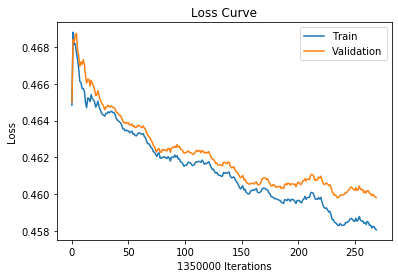

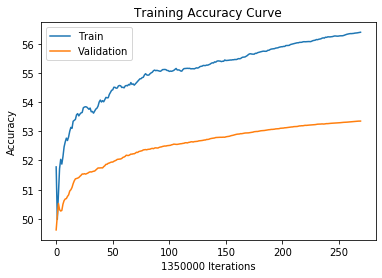

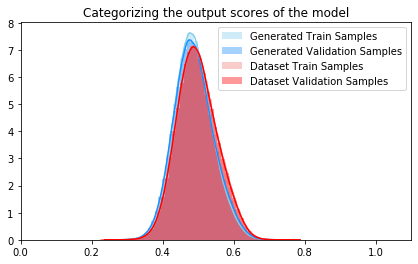

 50%|█████     | 50009/100000 [09:28<4:18:47,  3.22it/s]

Training Accuracy at epoch 13: 56.39681481481482
Validation Accuracy epoch 13: 53.35103703703704
AUC epoch 13: 0.5551948148148148
Train Precision:  0.37151854568877596
Train Recall:  0.4665718413856176


100%|█████████▉| 99995/100000 [18:50<00:00, 96.89it/s]  

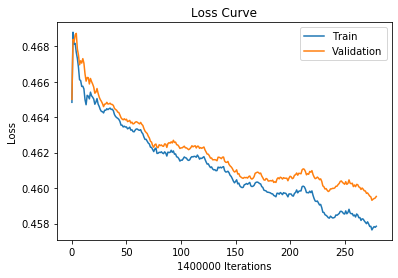

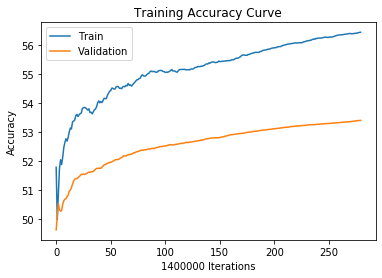

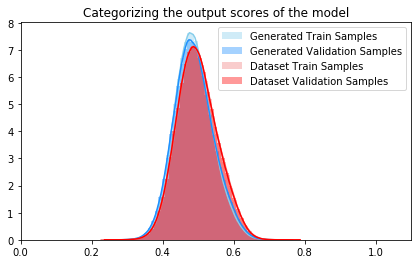

  0%|          | 11/100000 [00:00<16:28, 101.14it/s]

Training Accuracy at epoch 13: 56.43985714285714
Validation Accuracy epoch 13: 53.39785714285714
AUC epoch 13: 0.5555635714285714
Train Precision:  0.3720858424772258
Train Recall:  0.467360005200039
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 14  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49999/100000 [09:18<10:15, 81.22it/s] 

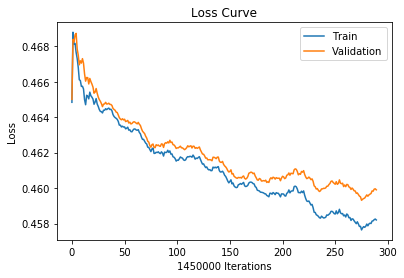

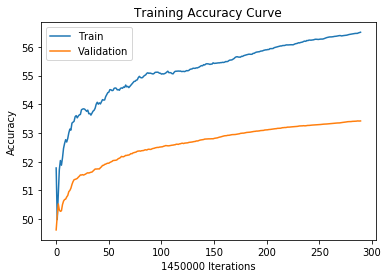

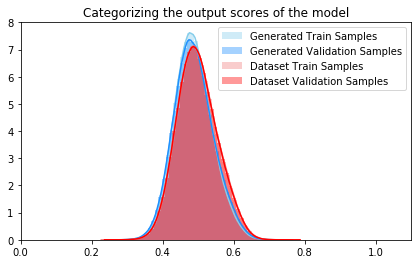

 50%|█████     | 50020/100000 [09:29<3:30:56,  3.95it/s]

Training Accuracy at epoch 14: 56.51331034482759
Validation Accuracy epoch 14: 53.41993103448276
AUC epoch 14: 0.5560006896551725
Train Precision:  0.3725661780791949
Train Recall:  0.4667783957049182


100%|█████████▉| 99999/100000 [18:46<00:00, 88.98it/s]  

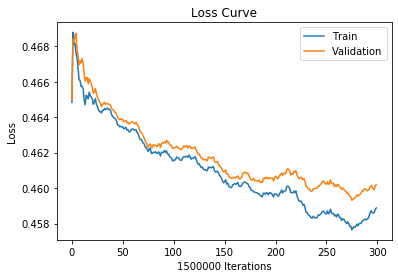

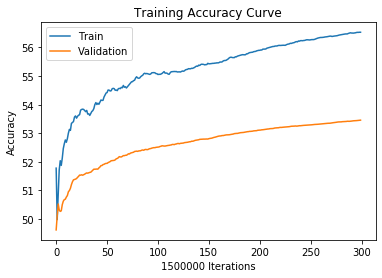

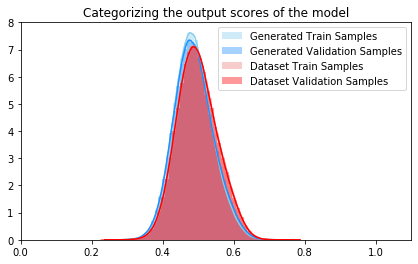

  0%|          | 11/100000 [00:00<15:42, 106.12it/s]

Training Accuracy at epoch 14: 56.532333333333334
Validation Accuracy epoch 14: 53.45793333333334
AUC epoch 14: 0.5562046666666667
Train Precision:  0.3732526184546688
Train Recall:  0.4684331718046534
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 15  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49996/100000 [09:16<08:40, 96.13it/s] 

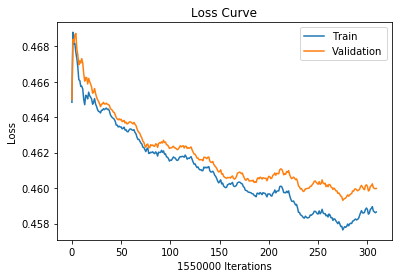

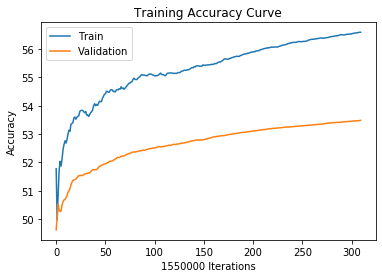

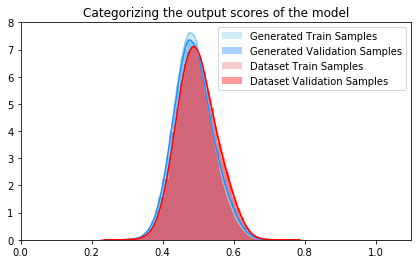

 50%|█████     | 50007/100000 [09:28<4:45:04,  2.92it/s]

Training Accuracy at epoch 15: 56.59696774193549
Validation Accuracy epoch 15: 53.48658064516129
AUC epoch 15: 0.5564967741935484
Train Precision:  0.3740988575134704
Train Recall:  0.4693499517838037


100%|█████████▉| 99993/100000 [18:47<00:00, 97.91it/s]  

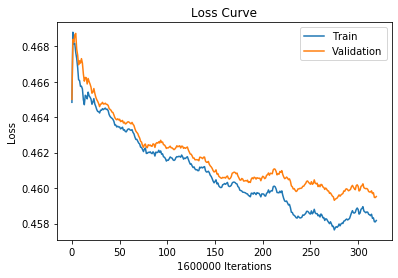

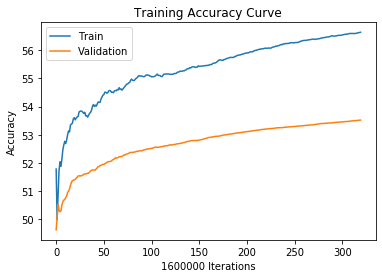

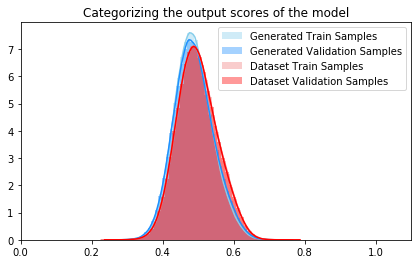

  0%|          | 10/100000 [00:00<17:10, 96.99it/s]

Training Accuracy at epoch 15: 56.6394375
Validation Accuracy epoch 15: 53.51975
AUC epoch 15: 0.5568525
Train Precision:  0.3747000027169565
Train Recall:  0.470380581530853
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 16  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49994/100000 [09:22<10:52, 76.63it/s] 

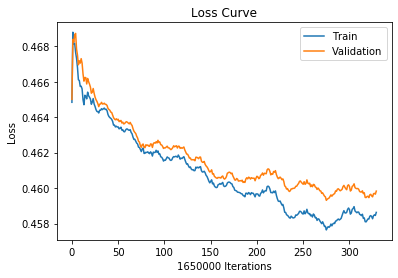

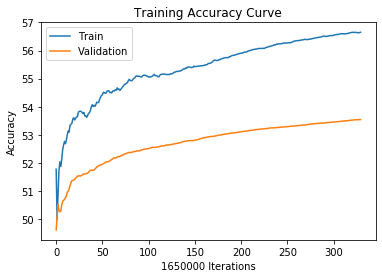

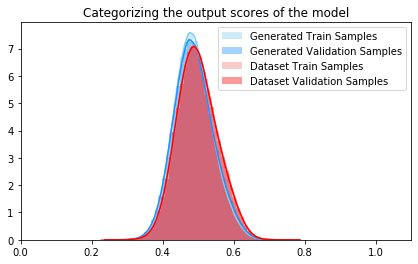

 50%|█████     | 50013/100000 [09:35<4:22:33,  3.17it/s]

Training Accuracy at epoch 16: 56.64939393939394
Validation Accuracy epoch 16: 53.54484848484849
AUC epoch 16: 0.557059393939394
Train Precision:  0.3752022830970199
Train Recall:  0.47189428186726085


100%|█████████▉| 99987/100000 [18:48<00:00, 92.73it/s]  

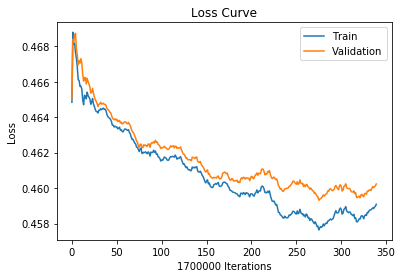

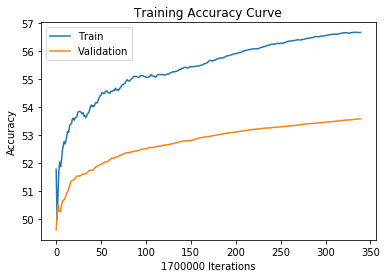

100%|█████████▉| 99987/100000 [19:00<00:00, 92.73it/s]

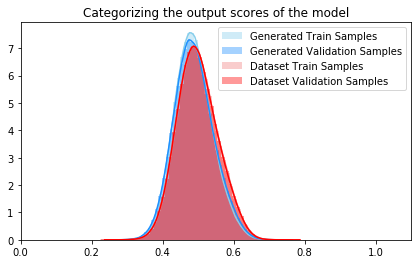

  0%|          | 11/100000 [00:00<15:43, 105.93it/s]

Training Accuracy at epoch 16: 56.65911764705882
Validation Accuracy epoch 16: 53.58164705882353
AUC epoch 16: 0.5572682352941176
Train Precision:  0.3757583301389995
Train Recall:  0.4734335848532048
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 17  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49997/100000 [09:15<08:34, 97.24it/s] 

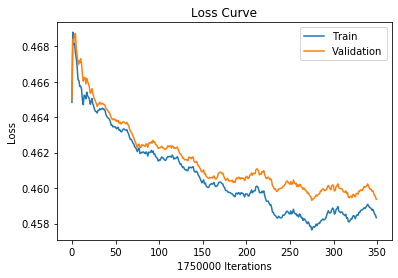

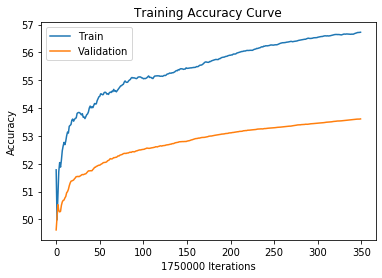

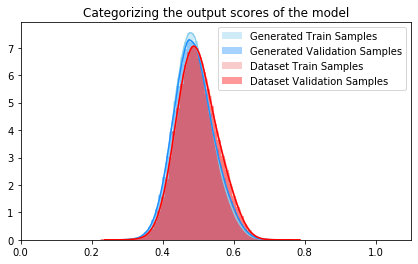

 50%|█████     | 50008/100000 [09:29<5:20:28,  2.60it/s]

Training Accuracy at epoch 17: 56.726057142857144
Validation Accuracy epoch 17: 53.61045714285714
AUC epoch 17: 0.5575131428571428
Train Precision:  0.3763085088673875
Train Recall:  0.47366388618074834


100%|█████████▉| 99996/100000 [18:49<00:00, 98.57it/s]  

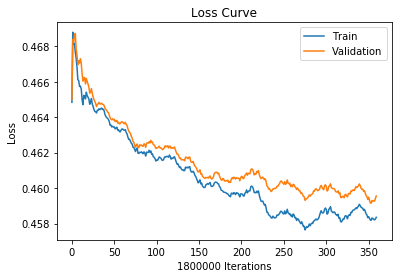

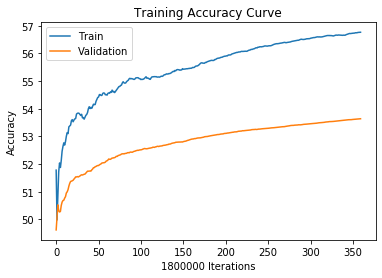

100%|█████████▉| 99996/100000 [19:00<00:00, 98.57it/s]

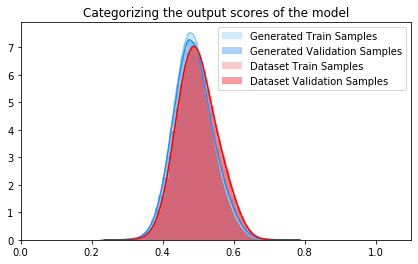

  0%|          | 10/100000 [00:00<17:29, 95.30it/s]

Training Accuracy at epoch 17: 56.76394444444445
Validation Accuracy epoch 17: 53.63755555555556
AUC epoch 17: 0.557725
Train Precision:  0.37670433558347566
Train Recall:  0.47387427124562076
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 18  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49989/100000 [09:18<10:59, 75.87it/s] 

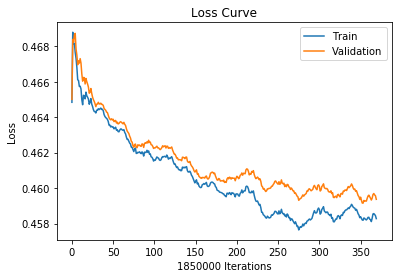

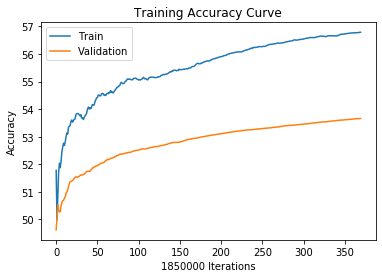

 50%|████▉     | 49989/100000 [09:30<10:59, 75.87it/s]

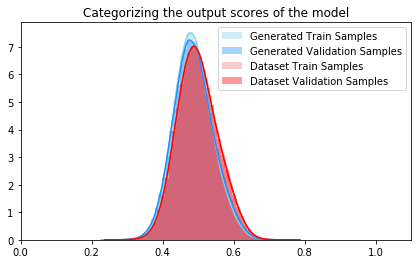

 50%|█████     | 50011/100000 [09:32<3:56:49,  3.52it/s]

Training Accuracy at epoch 18: 56.78767567567568
Validation Accuracy epoch 18: 53.65967567567568
AUC epoch 18: 0.5580832432432432
Train Precision:  0.37708997346334
Train Recall:  0.4745662496089572


100%|█████████▉| 99996/100000 [18:47<00:00, 87.18it/s]  

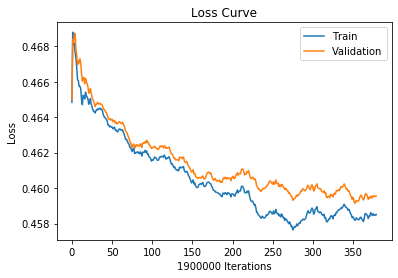

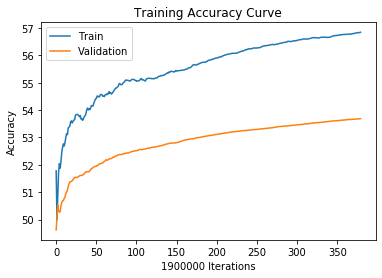

100%|█████████▉| 99996/100000 [19:00<00:00, 87.18it/s]

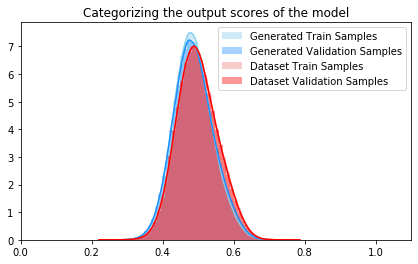

  0%|          | 10/100000 [00:00<16:42, 99.75it/s]

Training Accuracy at epoch 18: 56.84242105263158
Validation Accuracy epoch 18: 53.68384210526316
AUC epoch 18: 0.5583184210526316
Train Precision:  0.3774172743707977
Train Recall:  0.47421381239970267
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 19  with learning rate:  [0.009000000000000001]


 50%|████▉     | 49994/100000 [09:19<09:11, 90.61it/s] 

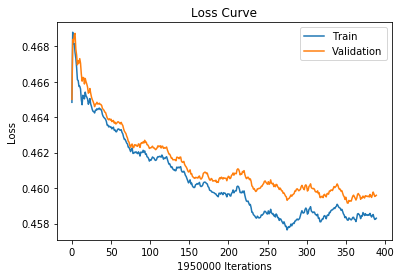

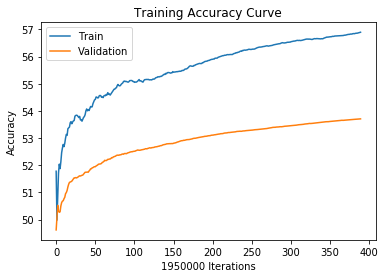

 50%|████▉     | 49994/100000 [09:30<09:11, 90.61it/s]

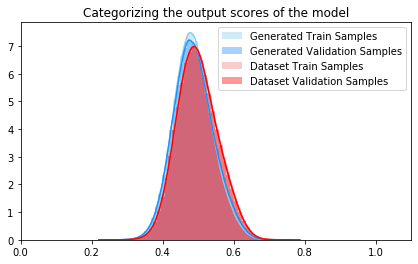

 50%|█████     | 50010/100000 [09:34<7:29:34,  1.85it/s] 

Training Accuracy at epoch 19: 56.89671794871795
Validation Accuracy epoch 19: 53.707794871794874
AUC epoch 19: 0.5585441025641026
Train Precision:  0.3779484868890121
Train Recall:  0.47462964978004385


100%|█████████▉| 99989/100000 [18:48<00:00, 97.55it/s]  

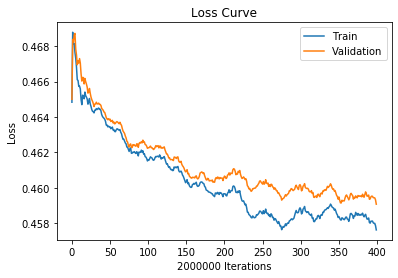

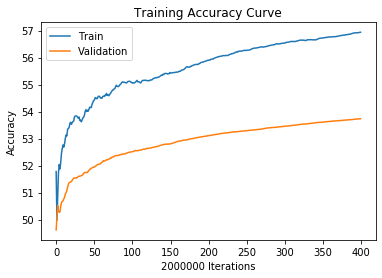

100%|█████████▉| 99989/100000 [19:00<00:00, 97.55it/s]

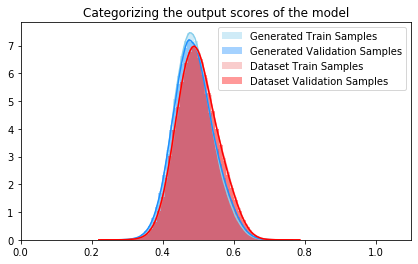

  0%|          | 10/100000 [00:00<17:20, 96.13it/s]

Training Accuracy at epoch 19: 56.937
Validation Accuracy epoch 19: 53.7346
AUC epoch 19: 0.55888
Train Precision:  0.3784371586678012
Train Recall:  0.4752166130912056
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 20  with learning rate:  [0.007290000000000001]


 50%|████▉     | 49999/100000 [09:16<10:08, 82.22it/s] 

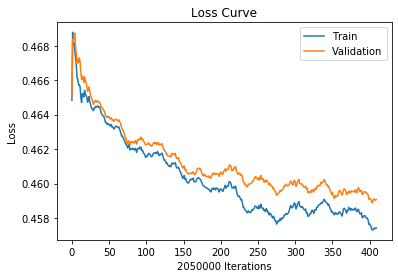

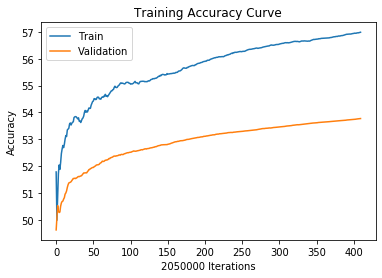

 50%|████▉     | 49999/100000 [09:30<10:08, 82.22it/s]

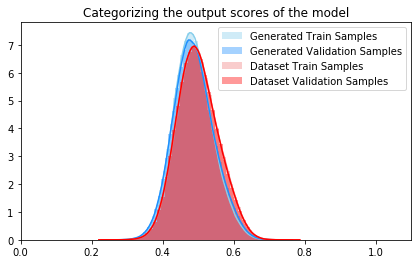

 50%|█████     | 50011/100000 [09:32<46:23:37,  3.34s/it]

Training Accuracy at epoch 20: 56.986048780487806
Validation Accuracy epoch 20: 53.77024390243903
AUC epoch 20: 0.5590926829268292
Train Precision:  0.37897942887024855
Train Recall:  0.4757999645117407


100%|█████████▉| 99993/100000 [18:49<00:00, 88.52it/s]   

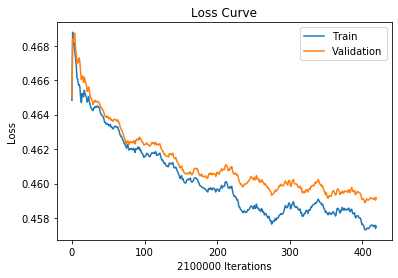

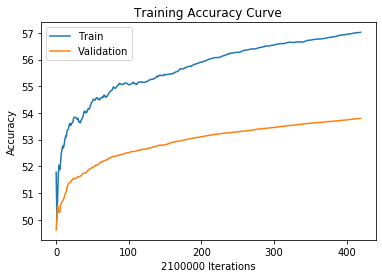

100%|█████████▉| 99993/100000 [19:00<00:00, 88.52it/s]

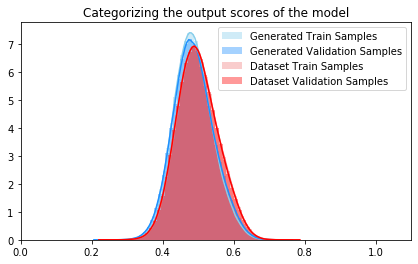

  0%|          | 12/100000 [00:00<14:28, 115.12it/s]

Training Accuracy at epoch 20: 57.02090476190476
Validation Accuracy epoch 20: 53.79719047619048
AUC epoch 20: 0.5593357142857143
Train Precision:  0.37940022328075546
Train Recall:  0.4763242375601926
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 21  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49997/100000 [09:16<08:07, 102.54it/s]

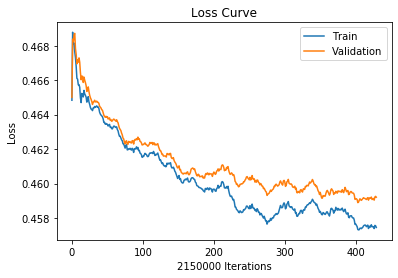

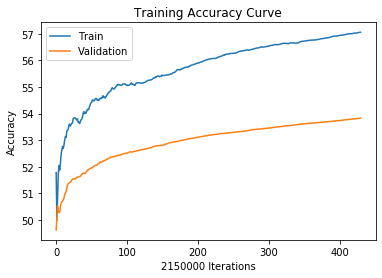

 50%|████▉     | 49997/100000 [09:30<08:07, 102.54it/s]

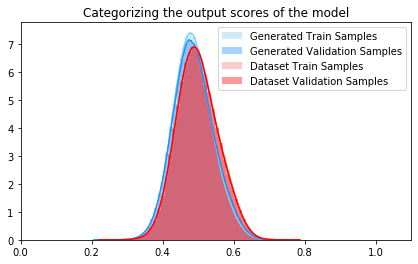

 50%|█████     | 50010/100000 [09:33<16:03:39,  1.16s/it]

Training Accuracy at epoch 21: 57.061488372093024
Validation Accuracy epoch 21: 53.825720930232556
AUC epoch 21: 0.5594976744186047
Train Precision:  0.3799215804317232
Train Recall:  0.4768529809390758


100%|█████████▉| 99997/100000 [18:50<00:00, 97.76it/s]   

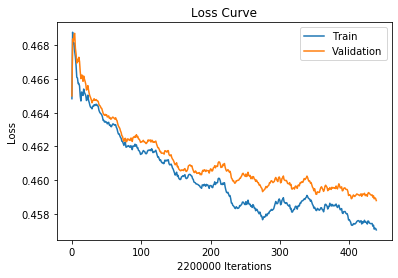

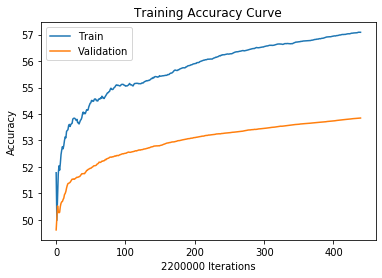

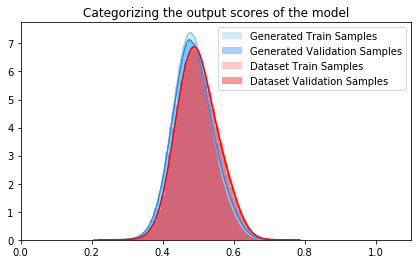

  0%|          | 9/100000 [00:00<18:53, 88.19it/s]

Training Accuracy at epoch 21: 57.087545454545456
Validation Accuracy epoch 21: 53.84709090909091
AUC epoch 21: 0.5597122727272728
Train Precision:  0.3804418977194604
Train Recall:  0.4779247790962748
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 22  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49999/100000 [09:13<10:01, 83.17it/s] 

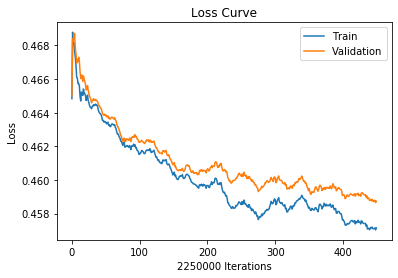

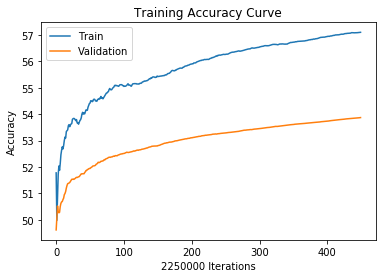

 50%|████▉     | 49999/100000 [09:30<10:01, 83.17it/s]

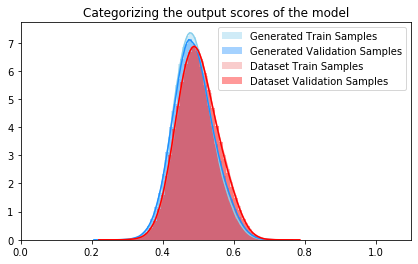

 50%|█████     | 50011/100000 [09:30<49:54:02,  3.59s/it]

Training Accuracy at epoch 22: 57.102
Validation Accuracy epoch 22: 53.8732
AUC epoch 22: 0.5598506666666667
Train Precision:  0.3807889121005141
Train Recall:  0.478933064705106


100%|█████████▉| 99994/100000 [18:45<00:00, 86.28it/s]   

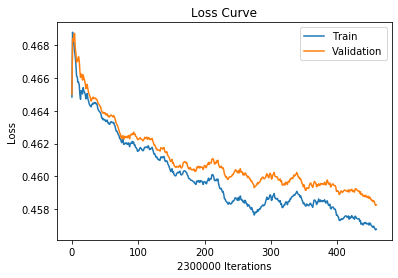

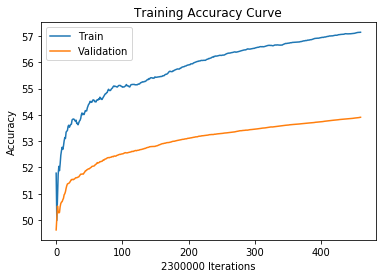

100%|█████████▉| 99994/100000 [19:00<00:00, 86.28it/s]

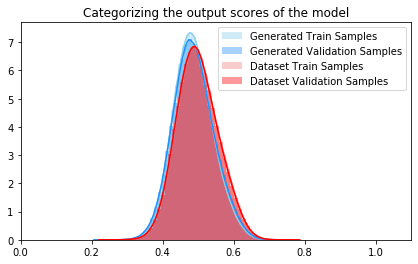

  0%|          | 11/100000 [00:00<15:58, 104.36it/s]

Training Accuracy at epoch 22: 57.14504347826087
Validation Accuracy epoch 22: 53.90765217391304
AUC epoch 22: 0.5599947826086956
Train Precision:  0.38118208522272956
Train Recall:  0.47928923910107324
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 23  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49990/100000 [09:17<09:10, 90.77it/s] 

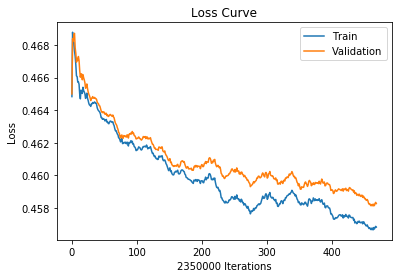

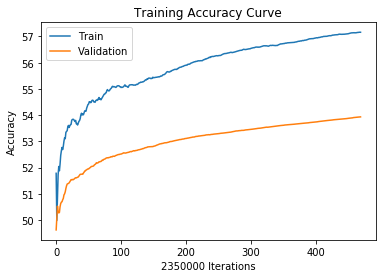

 50%|████▉     | 49990/100000 [09:30<09:10, 90.77it/s]

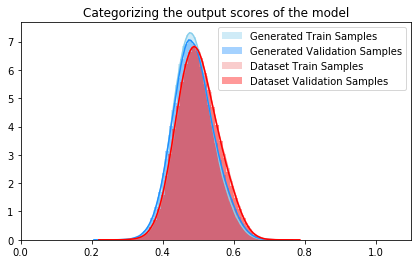

 50%|█████     | 50011/100000 [09:35<5:18:22,  2.62it/s]

Training Accuracy at epoch 23: 57.16191489361702
Validation Accuracy epoch 23: 53.9323829787234
AUC epoch 23: 0.5602161702127659
Train Precision:  0.3816080276436719
Train Recall:  0.480484027579875


100%|█████████▉| 99995/100000 [18:48<00:00, 99.67it/s]  

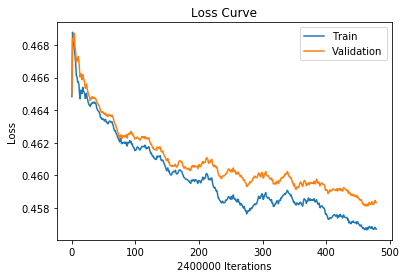

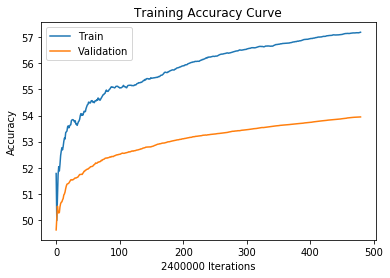

100%|█████████▉| 99995/100000 [19:00<00:00, 99.67it/s]

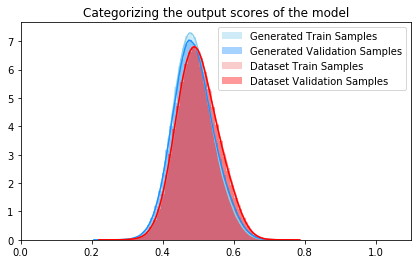

  0%|          | 9/100000 [00:00<18:40, 89.23it/s]

Training Accuracy at epoch 23: 57.18825
Validation Accuracy epoch 23: 53.9455
AUC epoch 23: 0.5604108333333333
Train Precision:  0.3819441311659474
Train Recall:  0.4810804121940964
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 24  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49996/100000 [09:15<09:58, 83.54it/s] 

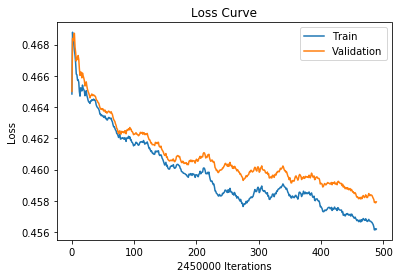

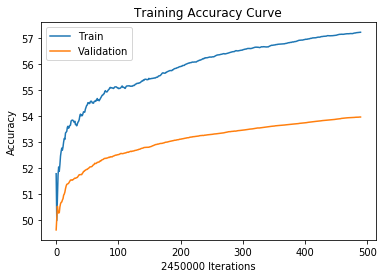

 50%|████▉     | 49996/100000 [09:30<09:58, 83.54it/s]

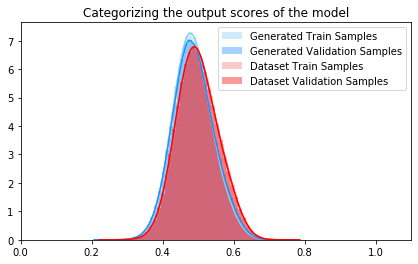

 50%|█████     | 50010/100000 [09:33<13:40:52,  1.01it/s]

Training Accuracy at epoch 24: 57.219755102040814
Validation Accuracy epoch 24: 53.960204081632654
AUC epoch 24: 0.5606351020408163
Train Precision:  0.38240850974453294
Train Recall:  0.48191882922919554


100%|█████████▉| 99991/100000 [18:42<00:00, 89.68it/s]   

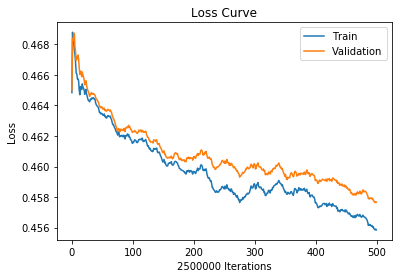

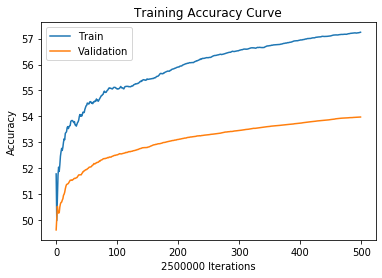

100%|█████████▉| 99991/100000 [19:00<00:00, 89.68it/s]

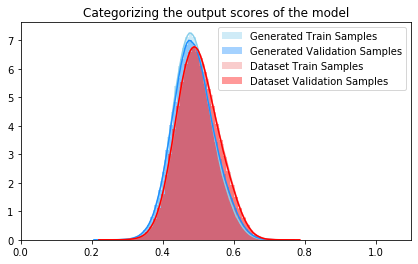

  0%|          | 10/100000 [00:00<17:52, 93.20it/s]

Training Accuracy at epoch 24: 57.24616
Validation Accuracy epoch 24: 53.97528
AUC epoch 24: 0.560856
Train Precision:  0.3828101045111965
Train Recall:  0.48274010460542666
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 25  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49989/100000 [09:11<09:04, 91.89it/s] 

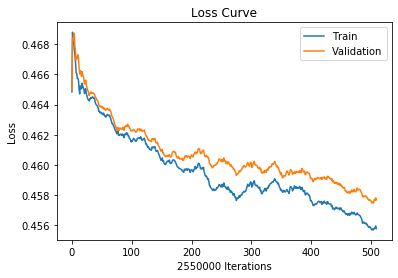

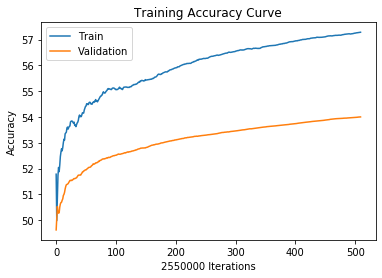

 50%|████▉     | 49989/100000 [09:30<09:04, 91.89it/s]

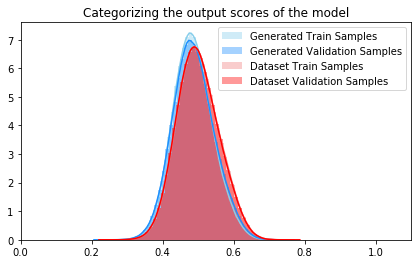

 50%|█████     | 50011/100000 [09:31<5:14:26,  2.65it/s]

Training Accuracy at epoch 25: 57.282196078431376
Validation Accuracy epoch 25: 53.999607843137255
AUC epoch 25: 0.5610196078431372
Train Precision:  0.3832278725573908
Train Recall:  0.4832168746286393


100%|█████████▉| 99990/100000 [18:47<00:00, 103.97it/s] 

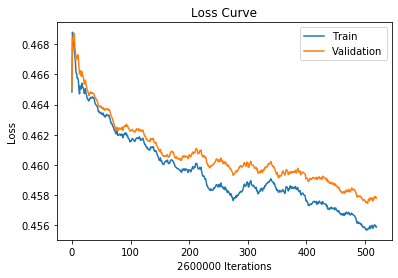

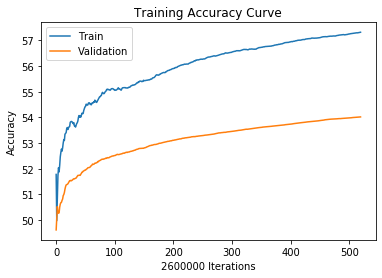

100%|█████████▉| 99990/100000 [19:00<00:00, 103.97it/s]

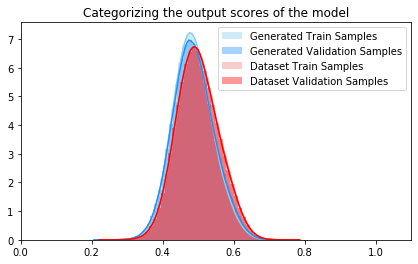

  0%|          | 12/100000 [00:00<14:19, 116.31it/s]

Training Accuracy at epoch 25: 57.314807692307696
Validation Accuracy epoch 25: 54.01826923076923
AUC epoch 25: 0.5611719230769231
Train Precision:  0.383719179214857
Train Recall:  0.4840411894406608
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 26  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49991/100000 [09:14<10:52, 76.68it/s] 

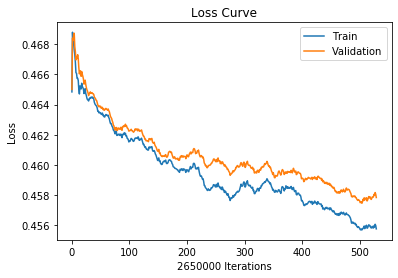

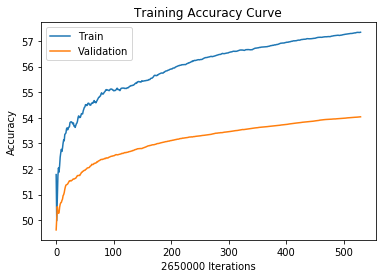

 50%|████▉     | 49991/100000 [09:30<10:52, 76.68it/s]

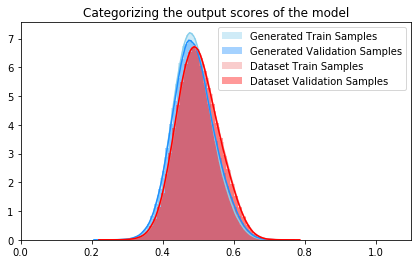

 50%|█████     | 50011/100000 [09:34<6:35:39,  2.11it/s]

Training Accuracy at epoch 26: 57.339132075471696
Validation Accuracy epoch 26: 54.03645283018868
AUC epoch 26: 0.5613407547169811
Train Precision:  0.38405606038778
Train Recall:  0.4846521668538028


100%|█████████▉| 99998/100000 [18:43<00:00, 84.41it/s]  

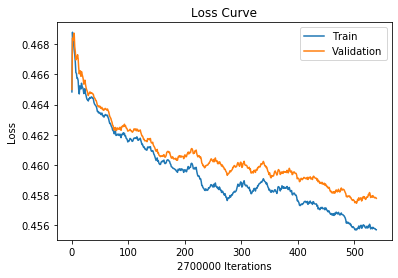

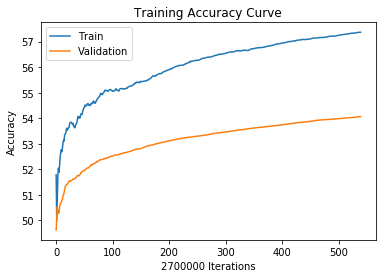

100%|█████████▉| 99998/100000 [19:00<00:00, 84.41it/s]

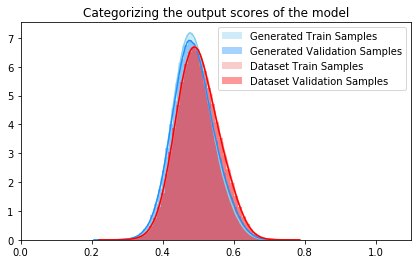

  0%|          | 11/100000 [00:00<15:32, 107.24it/s]

Training Accuracy at epoch 26: 57.3687037037037
Validation Accuracy epoch 26: 54.06092592592593
AUC epoch 26: 0.5614481481481481
Train Precision:  0.38451303128183156
Train Recall:  0.48542221873123986
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 27  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49996/100000 [09:07<08:44, 95.33it/s] 

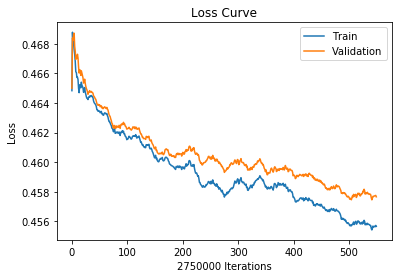

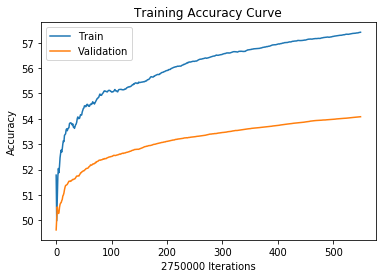

 50%|████▉     | 49996/100000 [09:20<08:44, 95.33it/s]

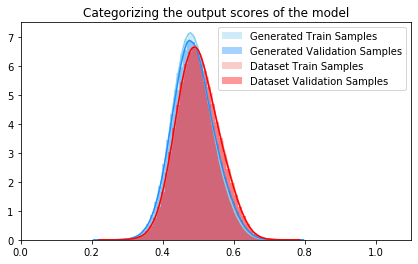

 50%|█████     | 50011/100000 [09:27<15:01:10,  1.08s/it]

Training Accuracy at epoch 27: 57.41149090909091
Validation Accuracy epoch 27: 54.0812
AUC epoch 27: 0.5616549090909091
Train Precision:  0.38492647636609373
Train Recall:  0.48576553626873925


100%|█████████▉| 99993/100000 [18:31<00:00, 99.47it/s]   

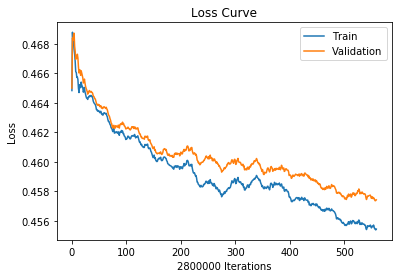

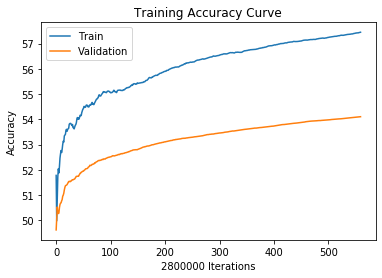

100%|█████████▉| 99993/100000 [18:50<00:00, 99.47it/s]

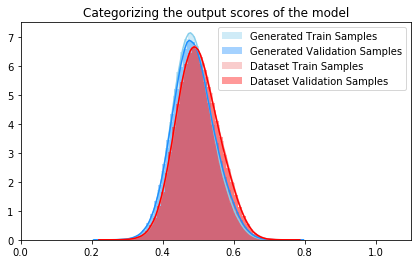

  0%|          | 10/100000 [00:00<17:02, 97.79it/s]

Training Accuracy at epoch 27: 57.45232142857143
Validation Accuracy epoch 27: 54.105535714285715
AUC epoch 27: 0.5618403571428572
Train Precision:  0.38525030508265123
Train Recall:  0.4858876794143146
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 28  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49993/100000 [09:10<11:09, 74.70it/s] 

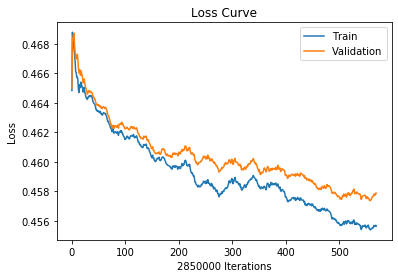

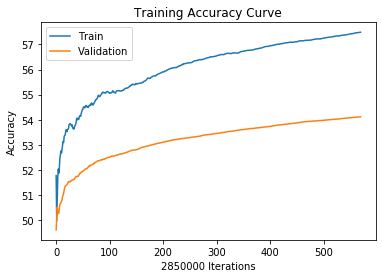

 50%|████▉     | 49993/100000 [09:30<11:09, 74.70it/s]

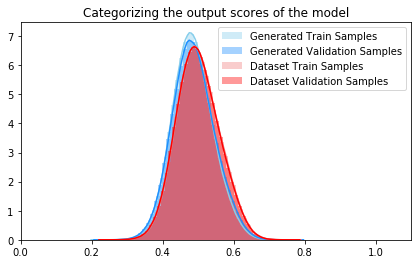

 50%|█████     | 50011/100000 [09:31<8:55:24,  1.56it/s] 

Training Accuracy at epoch 28: 57.48266666666667
Validation Accuracy epoch 28: 54.12038596491228
AUC epoch 28: 0.5620017543859649
Train Precision:  0.38566168536901163
Train Recall:  0.48647476139437557


100%|█████████▉| 99999/100000 [18:43<00:00, 87.35it/s]  

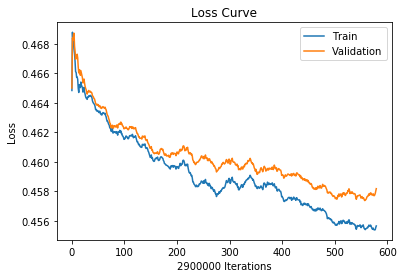

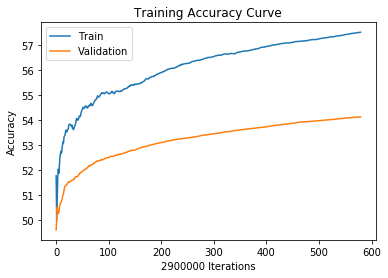

100%|█████████▉| 99999/100000 [19:00<00:00, 87.35it/s]

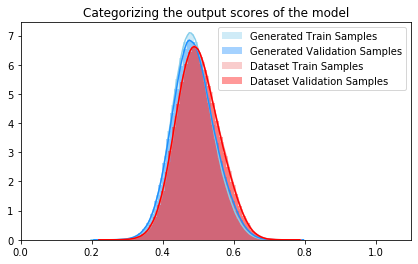

  0%|          | 10/100000 [00:00<16:42, 99.69it/s]

Training Accuracy at epoch 28: 57.51168965517241
Validation Accuracy epoch 28: 54.128103448275866
AUC epoch 28: 0.5621248275862069
Train Precision:  0.38596726745390514
Train Recall:  0.48672282466144795
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 29  with learning rate:  [0.008100000000000001]


 50%|████▉     | 49990/100000 [09:18<09:20, 89.15it/s] 

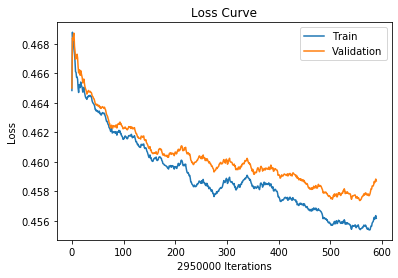

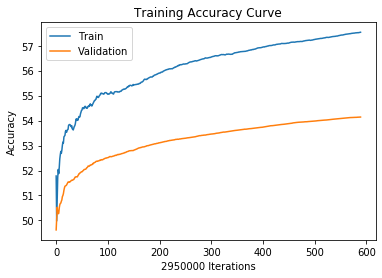

 50%|████▉     | 49990/100000 [09:30<09:20, 89.15it/s]

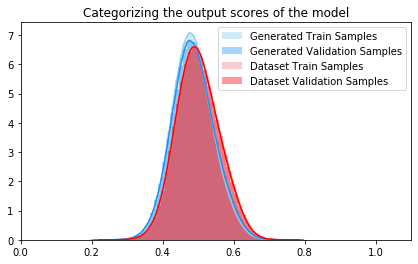

 50%|█████     | 50010/100000 [09:41<6:50:12,  2.03it/s]

Training Accuracy at epoch 29: 57.53833898305085
Validation Accuracy epoch 29: 54.1408813559322
AUC epoch 29: 0.562251186440678
Train Precision:  0.38634586436768126
Train Recall:  0.4871877307898135


100%|█████████▉| 99998/100000 [18:55<00:00, 100.13it/s] 

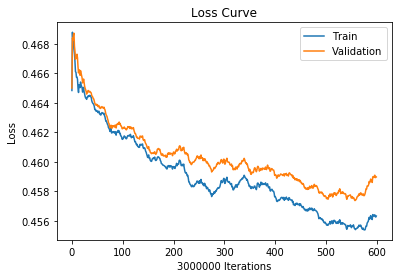

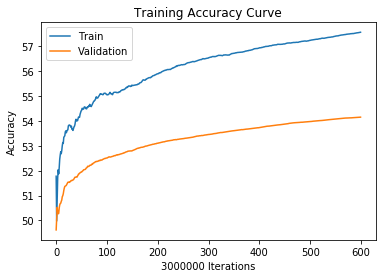

100%|█████████▉| 99998/100000 [19:10<00:00, 100.13it/s]

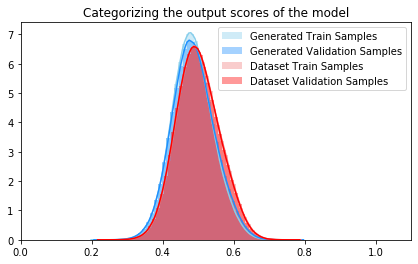

  0%|          | 11/100000 [00:00<16:21, 101.82it/s]

Training Accuracy at epoch 29: 57.57353333333333
Validation Accuracy epoch 29: 54.156733333333335
AUC epoch 29: 0.5623676666666667
Train Precision:  0.3867299383173512
Train Recall:  0.487560540788962
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 30  with learning rate:  [0.006561000000000002]


 50%|████▉     | 49993/100000 [09:10<10:59, 75.84it/s] 

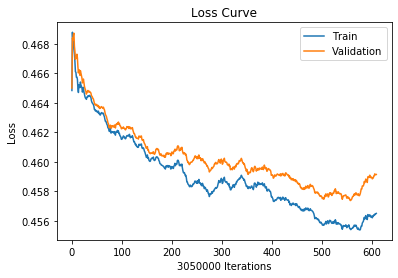

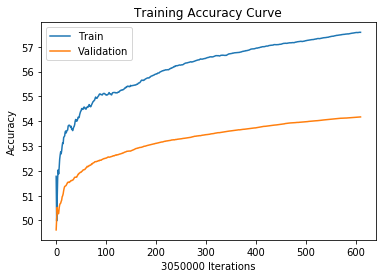

 50%|████▉     | 49993/100000 [09:30<10:59, 75.84it/s]

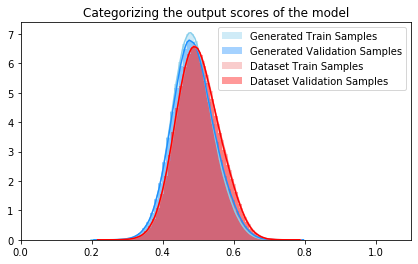

 50%|█████     | 50012/100000 [09:32<9:22:03,  1.48it/s] 

Training Accuracy at epoch 30: 57.584852459016396
Validation Accuracy epoch 30: 54.17393442622951
AUC epoch 30: 0.5625340983606557
Train Precision:  0.38709169655428605
Train Recall:  0.4885427334339219


100%|█████████▉| 99998/100000 [18:45<00:00, 99.24it/s]  

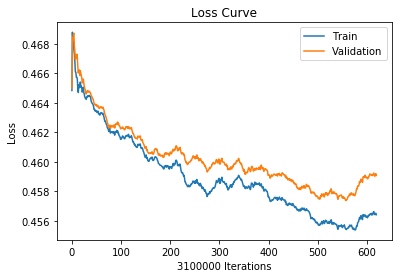

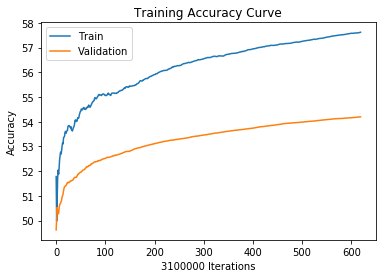

100%|█████████▉| 99998/100000 [19:00<00:00, 99.24it/s]

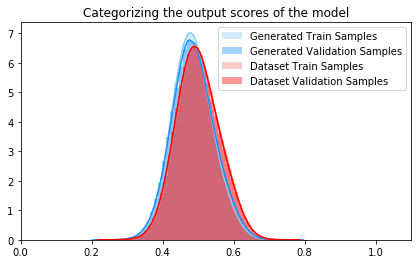

  0%|          | 11/100000 [00:00<16:49, 99.05it/s]

Training Accuracy at epoch 30: 57.61822580645161
Validation Accuracy epoch 30: 54.19587096774193
AUC epoch 30: 0.5627335483870968
Train Precision:  0.3873763737753586
Train Recall:  0.4887355840987441
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 31  with learning rate:  [0.007290000000000001]


 50%|████▉     | 49996/100000 [09:12<08:40, 96.00it/s] 

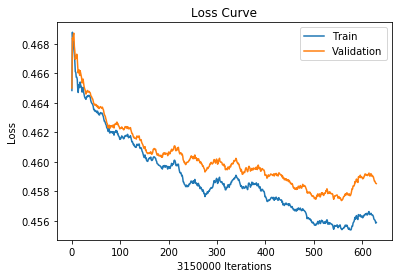

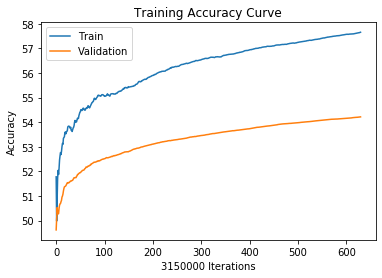

 50%|████▉     | 49996/100000 [09:30<08:40, 96.00it/s]

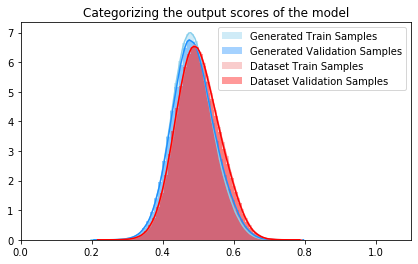

 50%|█████     | 50011/100000 [09:36<17:11:52,  1.24s/it]

Training Accuracy at epoch 31: 57.659238095238095
Validation Accuracy epoch 31: 54.21688888888889
AUC epoch 31: 0.5628876190476191
Train Precision:  0.3877978412586074
Train Recall:  0.48917400761335617


100%|█████████▉| 99991/100000 [18:44<00:00, 98.63it/s]   

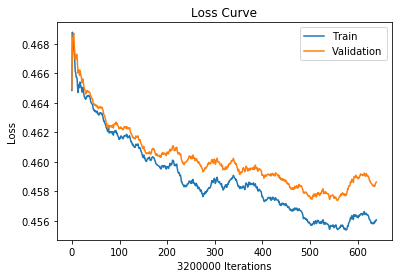

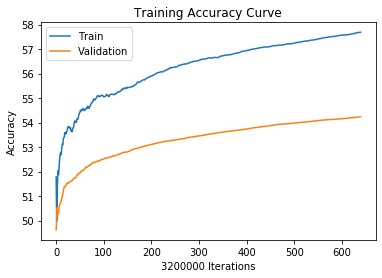

100%|█████████▉| 99991/100000 [19:00<00:00, 98.63it/s]

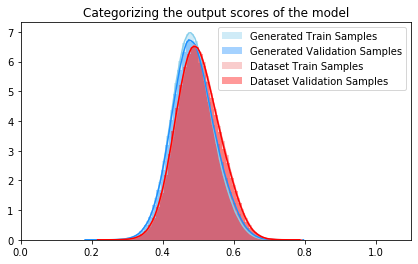

  0%|          | 11/100000 [00:00<16:04, 103.72it/s]

Training Accuracy at epoch 31: 57.68990625
Validation Accuracy epoch 31: 54.23775
AUC epoch 31: 0.563064375
Train Precision:  0.38820819366237885
Train Recall:  0.4897613070679887
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 32  with learning rate:  [0.007290000000000001]


 50%|████▉     | 49989/100000 [09:09<10:57, 76.08it/s] 

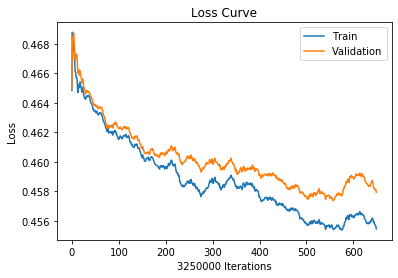

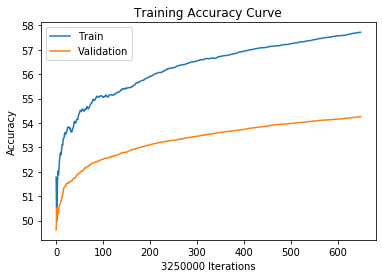

 50%|████▉     | 49989/100000 [09:20<10:57, 76.08it/s]

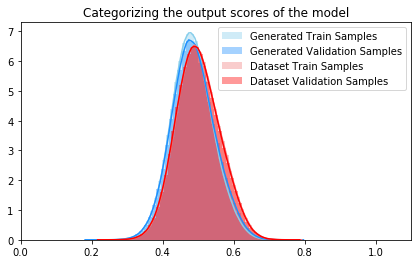

 50%|█████     | 50011/100000 [09:33<6:29:29,  2.14it/s]

Training Accuracy at epoch 32: 57.72086153846154
Validation Accuracy epoch 32: 54.25747692307692
AUC epoch 32: 0.5632621538461539
Train Precision:  0.3885993285550336
Train Recall:  0.4902706285889032


100%|█████████▉| 99999/100000 [18:43<00:00, 72.09it/s]  

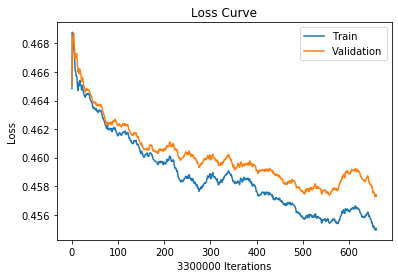

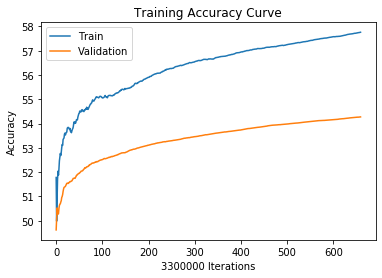

100%|█████████▉| 99999/100000 [19:00<00:00, 72.09it/s]

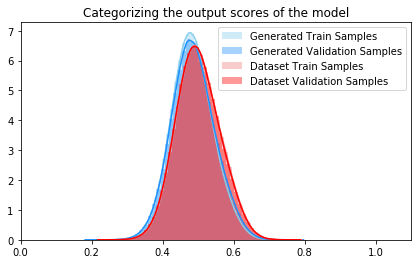

  0%|          | 8/100000 [00:00<21:20, 78.12it/s]

Training Accuracy at epoch 32: 57.75963636363636
Validation Accuracy epoch 32: 54.273
AUC epoch 32: 0.5633624242424242
Train Precision:  0.38893553557475313
Train Recall:  0.49048354169287806
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 33  with learning rate:  [0.007290000000000001]


 50%|████▉     | 49993/100000 [11:49<11:23, 73.17it/s]

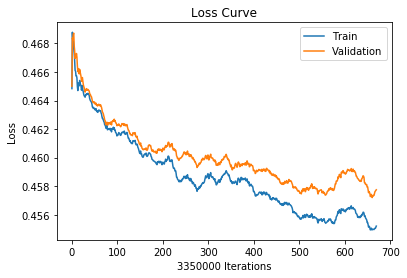

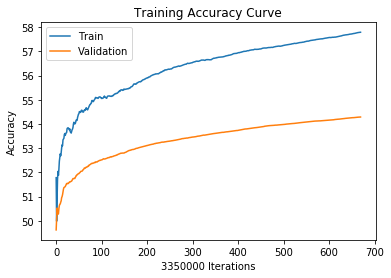

 50%|████▉     | 49993/100000 [12:00<11:23, 73.17it/s]

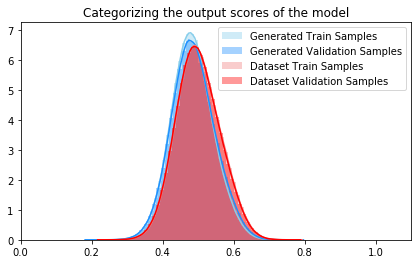

 50%|█████     | 50009/100000 [12:15<10:52:44,  1.28it/s]

Training Accuracy at epoch 33: 57.79376119402985
Validation Accuracy epoch 33: 54.288179104477614
AUC epoch 33: 0.5634665671641791
Train Precision:  0.3893591666863961
Train Recall:  0.49093058724131006


100%|█████████▉| 99994/100000 [22:51<00:00, 90.25it/s]   

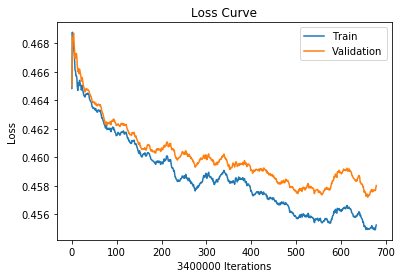

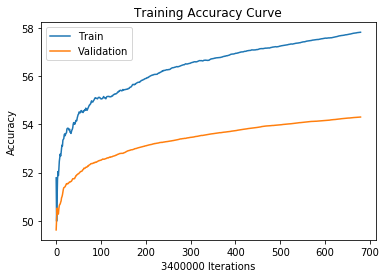

100%|█████████▉| 99994/100000 [23:10<00:00, 90.25it/s]

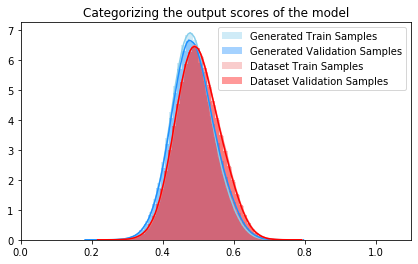

  0%|          | 10/100000 [00:00<17:59, 92.61it/s]

Training Accuracy at epoch 33: 57.8215
Validation Accuracy epoch 33: 54.303176470588234
AUC epoch 33: 0.5636108823529412
Train Precision:  0.38973629673191157
Train Recall:  0.4914011833454686
Saving to:  model_checkpoints/binary/TwoHeadedConv/10022020_2.pth
Starting epoch: 34  with learning rate:  [0.007290000000000001]


 27%|██▋       | 26663/100000 [05:12<14:19, 85.34it/s] 


KeyboardInterrupt: 

In [27]:
model = TwoHeadedConv()
model_name = model.name
model_id = "10022020_2"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 200
BATCH_SIZE = 64
cdf=False
if cdf:
   # For the CDF functions, we need to generate a dataset of new examples
    S_new = GeneratedDataset(10*m) 
gamma = 1e-2
print("Using encoding_style=", encoding_style)
classifier(model, train_pos, train_neg, train_gen, val_pos, val_neg, val_gen, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path, cdf=cdf)

## Evaluate the model

In [ ]:
# Calculate AUC
def eval_auc(model_name, model_id, use_blosum=False):
    if model_name == "ConvBaseline":
        model = ConvBaseline()
    elif model_name == "LinearBaseline":
        model = LinearBaseline()
    elif model_name == "LinearTwoHead":
        model = LinearTwoHead()
    elif model_name == "BlosumConvNet":
        model = BlosumConvNet()
    model.to(device)
    checkpointed_model = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
    checkpoint = torch.load(checkpointed_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    val_ds = [auc_ds_1, auc_ds_2]
    for ds in val_ds:
        auc_tracker = 0
        for i in tqdm.tqdm(range(10000)):
            idx = int(random.random()*len(ds))
            bio_sample, neg_sample, gen_sample = ds[idx]
            if model.single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True, use_blosum=use_blosum)
                bio_score = model(p)
                p, l = convert(neg_sample[0], neg_sample[1], neg_sample[2], single_alphabet=True, use_blosum=use_blosum)
                neg_score = model(p)
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], use_blosum=use_blosum)
                bio_score = model(a, p)
                a, p, l = convert(neg_sample[0], neg_sample[1], neg_sample[2], use_blosum=use_blosum)
                neg_score = model(a, p)
            if bio_score > neg_score:
                auc_tracker += 1

        print("Test AUC: ", auc_tracker/10000.0)

In [ ]:
eval_auc('ConvBaseline', "10012020", use_blosum=False)

In [ ]:
# Evaluate the decision threshold
def evaluate(model_name, model_id, dataset="3", use_gen=False, use_blosum=False):
    if model_name == "ConvBaseline":
        model = ConvBaseline()
    elif model_name == "LinearBaseline":
        model = LinearBaseline()
    elif model_name == "LinearTwoHead":
        model = LinearTwoHead()
    elif model_name == "TwoHeadedConv":
        model = TwoHeadedConv()
        
    model.to(device)
    checkpointed_model = 'model_checkpoints/binary/%s/%s.pth' % (model.name, model_id)
    checkpoint = torch.load(checkpointed_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    if dataset=="3":
        ds = auc_ds_1
    elif dataset=='4':
        ds = auc_ds_2
    thresholds = [i for i in range(1, 100)]
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    for i, t in enumerate(tqdm.tqdm(thresholds)):
        t = t*0.01
        tp, tn, fp, fn = 0, 0, 0, 0
        for i in range(1000):
            idx = int(random.random()*len(ds))
            bio_sample, neg_sample, gen_sample = ds[idx]
            if model.single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True, use_blosum=use_blosum)
                bio_score = model(p)
                if use_gen:
                    p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True, use_blosum=use_blosum)
                else:
                    p, l = convert(neg_sample[0], neg_sample[1], gen_sample[2], single_alphabet=True, use_blosum=use_blosum)
                gen_score = model(p) 
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], use_blosum=use_blosum)
                bio_score = model(a, p)
                if use_gen:
                    a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], use_blosum=use_blosum)
                else:
                    a, p, l = convert(neg_sample[0], neg_sample[1], gen_sample[2], use_blosum=use_blosum)
                gen_score = model(a, p)
            if bio_score >= t:
                tp += 1
            elif bio_score < t:
                fn += 1    
            if gen_score < t:
                tn += 1
            elif gen_score >= t:
                fp += 1


        try:
            precision = tp/float(tp + fp)
        except:
            precision = tp/1
        try:
            recall = tp/float(tp + fn)
        except:
            recall = tp/1

        precisions.append(precision)
        recalls.append(recall)

        # ROC stats
        fpr = fp/float(fp+tn)
        tpr = tp/float(tp+fn)
        fprs.append(fpr)
        tprs.append(tpr)
    
    roc_curve = zip(fprs, tprs)
    pr_curve = zip(recalls, precisions)
    
    roc_curve = sorted(roc_curve, key=lambda x: x[0])
    pr_curve = sorted(pr_curve, key=lambda x: x[0])
    
    roc_curve = list(zip(*roc_curve))
    pr_curve = list(zip(*pr_curve))
    return list(roc_curve[0]), list(roc_curve[1]), list(pr_curve[0]), list(pr_curve[1])

In [ ]:
## Generate ROC Curves for each method
methods = {'LinearBaseline': ['09302020_4', '09292020_3'],
           'ConvBaseline': ['9302020', '10012020'],
           'LinearTwoHead': ['10012020', '09302020'],
           'TwoHeadedConv': ['10012020_2', '10012020']}

colors = ["lightcoral", "crimson", "powderblue", 'navy', "lightgreen", "forestgreen", "gold", 'orange']
use_gen = True
method = 'roc'
for ds in ["3", "4"]:
    plt.figure(figsize=(10,10))
    for i, network in enumerate(methods):
        blosum_method = methods[network][0]
        oh_method = methods[network][1]
        
        fprs, tprs, recalls, precisions = evaluate(network, blosum_method, ds, use_gen=use_gen, use_blosum=True)

        plt.plot(fprs, tprs, c=colors[2*i], label=str(network) + " Blosum Encoding ")
        
        fprs, tprs, recalls, precisions = evaluate(network, oh_method, ds, use_gen=use_gen, use_blosum=False)
        
        plt.plot(fprs, tprs, c=colors[2*i + 1], label=str(network) + " One-hot Encoding ")
        
        
    
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    if use_gen:
        plt.title("ROC Curve, Test Dataset: " + str(ds) + " using generated NNK data")
    else:
        plt.title("ROC Curve, Test Dataset: " + str(ds) + " using negative samples")

    plt.show()
    
    